# _Modélisation de l'évolution de la circulation_

Par Virginie Slagmolen et Aidan Wastiaux

# INTRODUCTION

Les équations différentielles abordées ici essaient de décrire un modèle simple de convection. Il s'agit de voir l'évolution de la vitesse/densité d'un groupe de voitures réparties avec une densité initiale uniforme. La corrélation entre vitesse et densité est supposée linéaire, et décrite par l'équation suivante: 
$$\begin{equation}
V=V_{max}\left(1-\frac{\rho}{\rho_{max}}\right)
\end{equation}$$

Les questions posées sur cette évolution ne se rapportent qu'à des instants précis de l'évolution de la circulation. La [première partie](#PARTIE-1) de ce notebook ne décrira donc qu'une méthode particularisée pour ces questions. Une méthode plus générale (contrôle des temps où prendre les données) ne sera pas exploitée en vue d'optimiser nos calculs ici. Par contre, la [deuxième partie](#PARTIE-2) du notebook montrera l'évolution de la vitesse/densité des voitures le long de la route, dans un temps imparti.

# PARTIE 1

In [1]:
import numpy                       
from matplotlib import pyplot                 
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Nous importons nos bibliothèques (Numpy pour les tableaux et fonctions, matplotlib pour les graphiques). Les lignes 4,5 et 6 servent à la casse des caractères employés sur les graphiques.

### Attention, par souci de cohérence, il est nécessaire d'encoder toutes les valeurs des fonctions en kilomètres et en heures.

## 1) Fonction _traffic_

Ci-dessous, nous créons une fonction _traffic_ qui prend comme argument la vitesse maximale _vmax_ , la densité de voiture initiale _rhoinit_ sur toute la route (qui est la même que celle à l'origine, $x=0$ pour tout temps, par raccord des conditions initiales), ainsi que la durée _tmax_ sur laquelle on veut voir l'évolution.

Cette fonction a pour but de relever la densité et la vitesse des voitures le long de la route aux instants t=0 minutes, t=3 minutes et t=6 minutes (=_tmax_). Ces données seront stockées dans des tableaux.

La fonction nous retournera une liste de 2 objets: le premier est l'ensemble des densités qui nous seront utiles, et le second contient l'ensemble des vitesses à exploiter.

### a) Paramètres du problème:

1. le tronçon de route considéré: $L=11$ km
0. la densité maximale de voitures possible: $rhomax=250$ voitures/km (une voiture fait environ 4m)
0. l'excès de densité de voitures dont on veut voir l'évolution: $rho0=50$ voitures/km sur une partie des 11km tandis que le reste est à la densité _rhoinit_.

In [2]:
def traffic(vmax,rhoinit,tmax):
  
# Paramètres du problème & Données de calculs

    L = 11
    rhomax = 250
    nx = 51
    dx = L/(nx -1)
    dt = 0.001
    nt = int(tmax/dt)+1
    x = numpy.linspace(0,L,nx)
    rho0 = numpy.ones(nx)*rhoinit
    rho0[10:20] = 50
    
# Equation différentielle

    rho=rho0.copy()
    for n in range(1, nt):  
        rhon = rho.copy()
        rho[1:] = rhon[1:]-vmax*(rhon[1:]*(1-rhon[1:]/rhomax)-rhon[0:-1]*\
                                 (1-rhon[0:-1]/rhomax))*dt/dx
        rho[0]=rhoinit

# Stockage en tableaux

        if n==50:
            rho1=rho.copy() 

    r=numpy.empty_like([0,0,0],dtype=numpy.ndarray)
    r[0]=rho0
    r[1]=rho1
    r[2]=rho.copy()
    
    v=numpy.asarray([[vmax*(1-j/rhomax) for j in r[i]] for i in [0,1,2]])
    
    return r,v

### b) Données de calculs
0. nx est le nombre de points pour la discrétisation spatiale sur la route;
0. dx est l'espace entre chacun de ces points;
0. dt est la durée utilisée entre deux points de la discrétisation temporelle;
0. nt est le nombre de points "temporels" nécessaires pour que l'évolution dure _tmax_ (en heures);

0. x est le tableau de discrétisation spatial.

### c) Equation différentielle pour _rho_

La première boucle _for_ est l'application de la méthode d'Euler pour les équations différentielles au tableau initial de densité. La boucle ne s'arrêtera que lorsqu'elle aura parcouru toute la discrétisation du temps.

Pour résoudre l'équation aux dérivées partielles (celle pour calculer rho), il a fallu la discrétiser. Deux manières sont possibles :

* discrétiser en suivant l'équation 
$\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x}=0$
* discrétiser en suivant l'équation 
$\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0$

Analytiquement, les deux manières se valent car par la "chain rule" appliquée à la relation $F=V\rho$, on peut passer de l'un à l'autre facilement.
Cependant, numériquement il existe une différence qui est notable dans les valeurs obtenues à la fin.

Premièrement, considérons le cas où nous discrétisons la première équation. Nous utilisons la _forward-difference_ pour la partie temporelle et la _backward-difference_ pour la partie spatiale. Ainsi nous obtenons la formule suivante :
$$ \frac{\rho_i^{n+1}-\rho_i^n}{\Delta t}+V_{max}\left(1-\frac{2 \rho_i^n}{\rho_{max}}\right)\frac{\rho_i^n-\rho_{i-1}^n}{\Delta x}$$
Alors que lorsque nous discrétisons selon la deuxième méthode, nous obtenons :
$$ \frac{\rho_i^{n+1}-\rho_i^n}{\Delta t}+V_{max}\left[\left(1-\frac{2 \rho_i^n}{\rho_{max}}\right)\rho_i^n - \left(1-\frac{2 \rho_{i-1}^n}{\rho_{max}}\right)\rho_{i-1}^n\right]\frac{1}{\Delta x} $$

Remarquons que les deux équations ne sont pas les mêmes, il est donc logique qu'elles nous donnent des valeurs différentes pour rho.  Comment devons-nous choisir la discrétisation?

Nous imposons que $$ \int_{\rho(t_0)}^{\rho(t_{max})} \frac{\partial F}{\partial x} d x = F(\rho(t_{max})-F(\rho(t_0)).$$

En effet, il est plus logique d'imposer que F soit conservé, plutôt que la densité. F est le flux de voitures, c'est-à-dire le nombre de voitures par unité de temps qui passent par un point de la route, et on trouve plus physique que la variation interne de la densité de voiture ne dépende que des variations aux extrémités. D'où le fait que l'intégrale sur ... ne puisse dépendre que de la valeur de F aux bords.

Ainsi si on discrétise $ \frac{\partial F}{\partial x} $ par les deux méthodes, on obtient :

\begin{align}
\int_{\rho(t_0)}^{\rho(t_{max})} \frac{\partial F}{\partial x} d x &\approx \sum_{i=1}^{N} V_{max}\left(1-\frac{2 \rho_i^n}{\rho_{max}}\right)\frac{\rho_i^n-\rho_{i-1}^n}{\Delta x} \Delta x\\
                                                        &= V_{max} (\rho_N - \rho_0) - \frac{2 V_{max}}{\rho_{max}}[\rho_1(\rho_1-\rho_0)+\rho_2(\rho_2-\rho_1)+ ... + \rho_N(\rho_N - \rho_{N-1})] \\
                                                        &\ne F(\rho(t_{max}) - F(\rho(t_0)
\end{align}

\begin{align}
\int_{\rho(t_0)}^{\rho(t_{max})} \frac{\partial F}{\partial x} d x &\approx \sum_{i=1}^{N} V_{max}\left[\left(1-\frac{2 \rho_i^n}{\rho_{max}}\right)\rho_i^n - \left(1-\frac{2 \rho_{i-1}^n}{\rho_{max}}\right)\rho_{i-1}^n\right]\frac{\Delta x}{\Delta x}\\
                                                        &= V_{max}\left(\rho_N-\frac{\rho_N^2}{\rho_{max}}\right)-V_{max}\left(\rho_0-\frac{\rho_0^2}{\rho_{max}}\right)\\
                                                        &=F(\rho(t_{max})-F(\rho(t_0))
\end{align}

La deuxième méthode est donc la plus correcte et c'est celle que l'on utilisera pour résoudre notre problème.

##### => Notations

Pour optimiser le calcul, nous utilisons la notation _rho[a:-b]_ pour faire comprendre que le calcul demandé doit être appliqué à toutes les entrées de _rho_ depuis le rang _a_ jusqu'au _b^eme_ rang avant la fin. L'utilisation d'une boucle _for_ pour la même opération prendrait plus de temps de calcul.

Nous imposons aussi que la valeur de la densité à l'origine soit la même à tout instant (=_rhoinit_). NB: Il s'agit d'une sécurité seulement puisque la boucle _for_ n'y touche pas.

### d) Stockage en tableaux

Nous avons besoin de 3 tableaux de données pour la densité:

0. en $t=0$ minutes (0 heure) , il suffit de récupérer _rho0_ ;
0. en $t=3$ minutes (0,05 heure, c'est-à-dire la 50eme itération de la boucle _for_ car le temps est discrétisté à $dt= 0.001$ heure), il suffit d'insérer une condition dans la boucle qui nous gardera le tableau fraîchement calculé dans la variable _rho1_ ;
0. en $t=6$ minutes ($t=tmax$, c'est-à-dire le dernier tableau de _rho_ calculé par la boucle), il suffit de récupérer justement ce dernier à la sortie de la boucle _for_ .

Par commodité de calcul, et aussi dans l'idée d'optimiser le calcul de la vitesse, nous stockons ces trois tableaux de données dans un tableau plus grand: _r_ (qu'il a d'abord fallu initialiser).

### e) Calcul de _v_

Nous voulons calculer le tableau de données pour la vitesse à ces mêmes instants $t=0$, $t=3$ et $t=6$ (minutes).

La notation employée permet de créer _v_ comme un tableau de 3 tableaux (variable _i_), chacun d'eux étant complété grâce à son tableau de _r_ respectif.

0. Le tableau v[0] est créé à partir de r[0] : ce sont les vitesses et densités locales à $t=0$ minutes ;
0. Le tableau v[1] ————————— r[1] —————————————————— $t=3$ minutes ;
0. Le tableau v[2] ————————— r[2] —————————————————— $t=6$ minutes .

Le calcul de chacun de ces _v[i]_ se fait grâce à la formule
\begin{equation}
V=V_{max}\left(1-\frac{\rho}{\rho_{max}}\right)
\end{equation}
en extrayant avec _j_ les données stockées dans _r[i]_ .

## 2) Réponses aux questions

In [3]:
def moyennetab(a):
    l=len(a)
    s=0
    for i in numpy.arange(0,l):
        s=s+a[i]
    m=s/l
    return m

Ceci est une petite fonction permettant de calculer la moyenne arithmétique des données d'un tableau pris comme argument: la boucle _for_ somme toutes les données, puis on divise cette somme par le nombre d'éléments, c'est-à-dire la taille du tableau (_len(a)_).

Maintenant qu'on a toutes les fonctions nécessaires pour répondre aux questions, il suffit de les appeler pour les données de l'énoncé.

#### Exercice 1

In [4]:
[r,v]=traffic(80,10,0.1)

vmin=numpy.zeros(2)
vmin[0]=min(v[0])
vmin[1]=min(v[2])

for i,j in enumerate([0,6]):
    print("La vitesse minimum à t=", j ,"minutes est {:.2f} km/h".format(vmin[i]),\
          "c'est-à-dire, {:.2f} m/s".format(vmin[i]/3.6))


vmoy=moyennetab(v[1])
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vmoy),\
     "c'est-à-dire, {:.2f} m/s".format(vmoy/3.6))

La vitesse minimum à t= 0 minutes est 64.00 km/h c'est-à-dire, 17.78 m/s
La vitesse minimum à t= 6 minutes est 67.62 km/h c'est-à-dire, 18.78 m/s
La vitesse moyenne à t= 3 minutes est 74.29 km/h c'est-à-dire, 20.64 m/s


r et v reprennent les données calculées pour $vmax=80$ km/h, $rhoinit=10$ voitures/km, $tmax=6$ minutes. Ainsi, vmin[0] est le minimum du tableau de vitesse à $t=0$ et vmin[2] pour $t=6$ minutes. vmoy est la moyenne du tableau de vitesses à $t=3$ minutes.

#### Exercice 2

In [5]:
[r,v]=traffic(136,20,0.05)

vmin=numpy.zeros(2)
vmin[0]=min(v[0])
vmin[1]=min(v[2])

for i,j in enumerate([0,3]):
    print("La vitesse minimum à t=", j ,"minutes est {:.2f} km/h".format(vmin[i]),\
          "c'est-à-dire, {:.2f} m/s".format(vmin[i]/3.6))


vmoy=moyennetab(v[1])
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vmoy),\
     "c'est-à-dire, {:.2f} m/s".format(vmoy/3.6))

La vitesse minimum à t= 0 minutes est 108.80 km/h c'est-à-dire, 30.22 m/s
La vitesse minimum à t= 3 minutes est 111.55 km/h c'est-à-dire, 30.99 m/s
La vitesse moyenne à t= 3 minutes est 121.94 km/h c'est-à-dire, 33.87 m/s


r et v reprennent les données calculées pour $vmax=136$ km/h, $rhoinit=20$ voitures/km, $tmax=3$ minutes. Ainsi, vmin[0] est le minimum du tableau de vitesse à $t=0$ et vmin[2] pour $t=3$ minutes. vmoy est la moyenne du tableau de vitesses à $t=3$ minutes.

### Interprétations

Comme les paramètres n'ont pas encore été initiés en dehors de la fonction, il est nécessaire de copier-coller cette partie maintenant pour que les graphiques puissent les utiliser.

On note r1/v1 le tableau de 3 tableaux (un pour chaque instant) pour la densité/vitesse lorsque $vmax=80$, $rhoinit=10$ et $tmax=0,1$. On note r2/v2 le tableau de 3 tableaux (un pour chaque instant) pour la densité/vitesse lorsque $vmax=136$, $rhoinit=20$ et $tmax=0,05$.

In [6]:
tmax=0.1
L = 11
rhomax = 250
nx = 51
dx = L/(nx -1)
dt = 0.001
nt = int(tmax/dt)+1
x = numpy.linspace(0,L,nx)
[r1,v1]=traffic(80,10,0.1)
[r2,v2]=traffic(136,20,0.05)

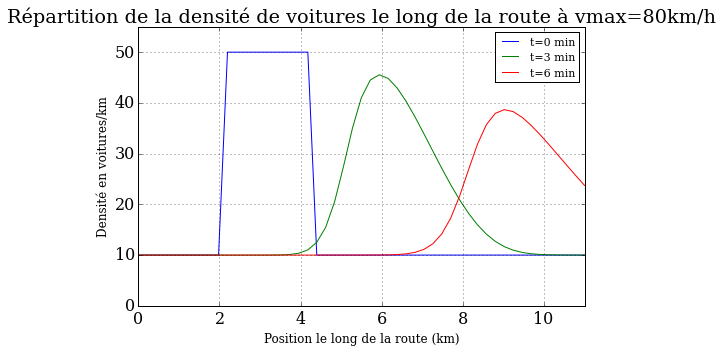

In [7]:
pyplot.figure(figsize=(8,5))
pyplot.xlim(0,11)
pyplot.xlabel("Position le long de la route (km)",fontsize=12)
pyplot.ylim(0,55)
pyplot.ylabel("Densité en voitures/km",fontsize=12)
pyplot.plot(x,r1[0])
pyplot.plot(x,r1[1])
pyplot.plot(x,r1[2])
pyplot.grid(True)
pyplot.legend(["t=0 min","t=3 min","t=6 min"],fontsize=11,loc=1)
pyplot.title("Répartition de la densité de voitures le long de la route à vmax=80km/h")
pyplot.show()

On remarque d'abord que la situation initiale (bloc de voitures à vitesse constante) se déforme:

* Diminution de la densité maximale
* Evolution à vitesse presque constante du pic (vitesse de groupe)
* Apparition d'une asymétrie dans la répartition de densité autour du pic

En effet, l'équation décrivant l'évolution de la densité est une équation de diffusion: il y a donc un amortissement physique de "l'intensité de la densité". Mais de manière phénoménologique, ceci est encore plus compréhensible si on se rappelle que le nombre de voitures est constant sur la route.
###### .
Comme la vitesse initiale des voitures est de l'ordre de 70 km/h, et vu que la vitesse maximale autorisée est de 80 km/h, les premières voitures du bloc vont s'en échapper progressivement puisque la circulation est moins dense devant elle. Au fur et à mesure qu'elles avancent, elles vont libérer de la place, ce qui va favoriser le départ des voitures au rang suivant. Pendant ce temps, les voitures plus en arrière n'ont pas encore eu la possibilité d'avancer et évoluent donc toujours avec cette vitesse de départ moins grande.

Ceci provoque donc une dispersion de la concentration en voitures dans le bloc, ce qui est synonyme d'une diminution du pic de densité de voitures. De plus, cette dispersion est asymétrique puisque les voitures à l'avant vont plus vite.

Il peut sembler étrange, étant donné que la densité associée au pic change, que la vitesse du pic soit constante vu qu'on a la relation
$$\begin{equation}
V=V_{max}(1-\frac{\rho}{\rho_{max}})
\end{equation}$$

En effet, ce n'est pas strictement le cas puisqu'on observe précisément que les vitesses minimales (associées aux densités maximales) sont respectivement (en km/h) 64,0  65,5 et 67,6 . Par conséquent, si la vitesse instantanée du pic à tendance à augmenter, il n'est pas possible que sa vitesse moyenne soit constante.

Cependant, la variation de vitesse entre $t=0$ et $t=6$ est de 3,6 km/h, ce qui est très faible. Théoriquement, si le pic avançait à $v= 64,0$ km/h, après 6 minutes il arriverait à la position $x= 3 + 6.4 = 9.4$ km .
On observe d'autre part que le pic de densité se trouve à la position $x= 9.02$ km .
La différence est tout à fait négligeable par rapport à la distance totale parcourue (de l'ordre de 4,2%).

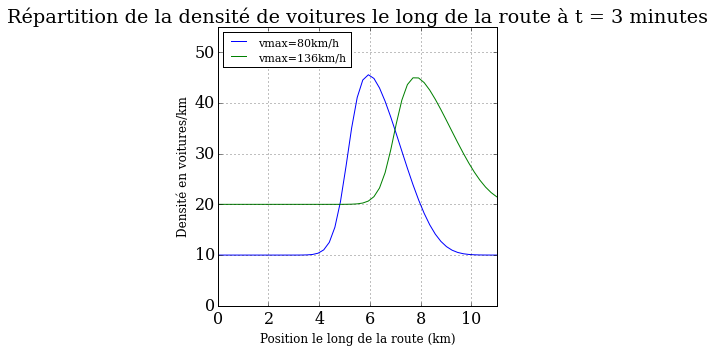

In [8]:
pyplot.figure(figsize=(5,5))
pyplot.xlim(0,11)
pyplot.xlabel("Position le long de la route (km)",fontsize=12)
pyplot.ylim(0,55)
pyplot.ylabel("Densité en voitures/km",fontsize=12)
pyplot.grid(True)
pyplot.plot(x,r1[1])
pyplot.plot(x,r2[1])
pyplot.legend(["vmax=80km/h","vmax=136km/h"],fontsize=11,loc=2)
pyplot.title("Répartition de la densité de voitures le long de la route à t = 3 minutes")
pyplot.show()

Ici, nous avons changer deux paramètres simultanément : l'intensité initiale et la vitesse maximale pour les voitures. Nous remarquons que la hauteur des pics est plus au moins la même. Cependant, le pic vert est plus en avant que le pic bleu puisque la vitesse de groupe du bleu est plus petite que celle du vert. De même le pic vert est plus étalé puisque le bloc de voitures de départ évoluait à une vitesse initiale plus élévée (il a donc pu se disperser plus vite).

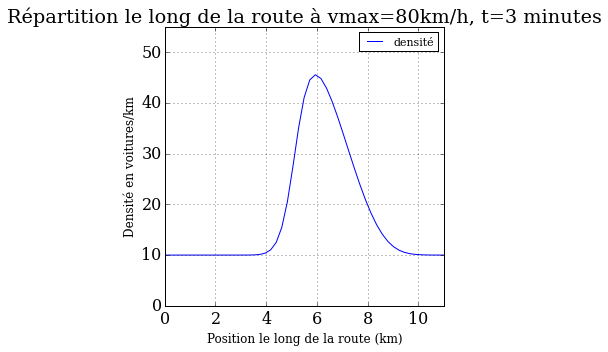

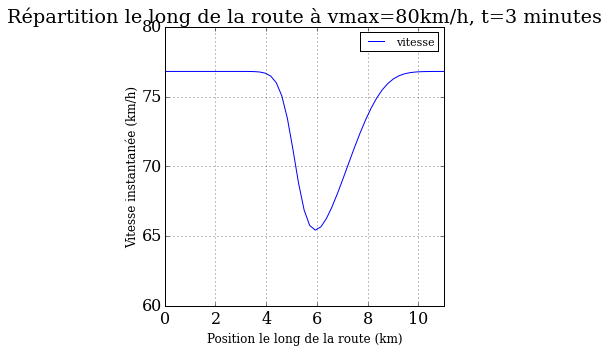

In [9]:
pyplot.figure(figsize=(5,5))
pyplot.grid(True)
pyplot.xlim(0,11)
pyplot.xlabel("Position le long de la route (km)",fontsize=12)
pyplot.ylim(0,55)
pyplot.ylabel("Densité en voitures/km",fontsize=12)
pyplot.plot(x,r1[1])
pyplot.legend(["densité"],fontsize=11,loc=1)
pyplot.title("Répartition le long de la route à vmax=80km/h, t=3 minutes")
pyplot.show()

pyplot.figure(figsize=(5,5))
pyplot.grid(True)
pyplot.xlim(0,11)
pyplot.xlabel("Position le long de la route (km)",fontsize=12)
pyplot.ylim(60,80)
pyplot.ylabel("Vitesse instantanée (km/h)",fontsize=12)
pyplot.plot(x,v1[1])
pyplot.legend(["vitesse"],fontsize=11,loc=1)
pyplot.title("Répartition le long de la route à vmax=80km/h, t=3 minutes")
pyplot.show()

En regardant les graphiques pour la vitesse et la densité dans les mêmes conditions, on constate qu'ils sont tout à fait similaires. Ceci n'est pas étonnant puisqu'ils sont reliés par une relation linéaire, le graphique de la vitesse est simplement inversé et réduit.

La raison du creux dans le graphique de la vitesse a été détaillée [ici](#. "Pic de densité, creux de vitesse") en même temps que l'allure du pic de densité. 

# PARTIE 2

Si on se débarasse des contraintes de l'exercice, on peut modéliser l'évolution temporelle de la densité et de la vitesse le long de la route. Pour représenter ce graphique évolutif, nous allons simplement stocker tous les tableaux de données au fur et à mesure que la fonction _traffic_ les crée. Nous allons ensuite les appeler et les faire défiler sous vos yeux ébahis. Nous ne pouvions pas utiliser cette méthode avant parce que cela aurait utilisé trop de mémoire inutilement.

In [10]:
import numpy                       
from matplotlib import pyplot                 
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

Nous utilisons ici la même syntaxe pour générer des tableaux de tableaux que celle utilisée pour créer _r_ et _v_ dans la fonction _traffic_. Voici un exemple pour rappel:

In [11]:
# Illustration des assignations de tableaux
nx=51
dt=.001
tmax=0.1
vmax=80
nt=int(tmax/dt)+1
# créer et initialiser le tableau en même temps
anim=numpy.asarray([[1 for i in range(nx)] for j in range(nt)])

# calculer un nouveau tableau de tableaux à partir du précédent
v=numpy.asarray([[vmax*(1-i/rhomax) for i in anim[j]] for j in range(nt)])
print(v) # on obtient bien un tableau de nt tableaux de taille len(anim[j]) = nx

[[ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]
 [ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]
 [ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]
 ..., 
 [ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]
 [ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]
 [ 79.68  79.68  79.68 ...,  79.68  79.68  79.68]]


Nous créons la fonction _animtraffic_ qui va stocker TOUS les tableaux de données de densité dans un seul (_animrho_), et pour la vitesse dans _animv_. A part ça, le code est strictement identique à celui pour la fonction _traffic_.

In [12]:
def animtraffic(vmax,rhoinit,tmax):
    
    L = 11
    rhomax = 250
    nx = 51
    dx = L/(nx -1)
    dt = 0.001
    nt = int(tmax/dt)+1
    x = numpy.linspace(0,L,nx)
    rho0 = numpy.ones(nx)*rhoinit
    rho0[10:20] = 50
    rho=rho0.copy()
    animrho=[[0 for i in range(nx)] for j in range(nt)]
    # animrho va remplacer r qui ne stockait
    # que trois données de rho
    animrho[0]=rho.copy()
    
    for n in range(1, nt):
        rhon = rho.copy()
        rho[1:] = rhon[1:]-vmax*(rhon[1:]*(1-rhon[1:]/rhomax)-rhon[0:-1]*\
                                 (1-rhon[0:-1]/rhomax))*dt/dx
        rho[0]=rhoinit
        animrho[n]=rho.copy()

    animv=[[vmax*(1-i/rhomax) for i in animrho[j]] for j in range(nt)]
    
    return animrho,animv

Comme la mise en animation nécessite des paramètres à encoder à la main (_vmax_ etc.), nous créons une fonction qui renverra une animation avec les paramètres souhaités (= ceux de la fonction _animtraffic_).

Etant donné que notre fonction _animtraffic_ calcule tous les tableaux nécessaires pour générer l'animation, la fonction définie pour l'animation ne fera que chercher les tableaux de données dans le bon tableau de tableaux (d'abord le tableau de tableaux _animv_ pour l'animation _animationvitesse_ , et ensuite le tableau de talbeaux _animrho_ pour l'animation _animationdensite_).

In [32]:
def animationvitesse(vmax,rhoinit,tmax):
    L=11
    nx=51
    dt = 0.001
    nt = int(tmax/dt)+1
    x=numpy.linspace(0,L,nx)
    animv=animtraffic(vmax,rhoinit,tmax)[1]

    fig=pyplot.figure(figsize=(8,5))
    ax=pyplot.axes(xlim=(0,11),ylim=(.6*vmax,vmax+5),xlabel="Position le long de la route (km)"\
                   ,ylabel="Vitesse instantanée (km/h)")
    line=ax.plot([],[],ls='--')[0]


    def anim(i):
        y=animv[i]
        line.set_data(x,y)
    
    return animation.FuncAnimation(fig,anim,frames=nt,interval=100)


In [33]:
def animationdensite(vmax,rhoinit,tmax):
    L=11
    nx=51
    dt = 0.001
    nt = int(tmax/dt)+1
    x=numpy.linspace(0,L,nx)
    animrho=animtraffic(vmax,rhoinit,tmax)[0]

    fig=pyplot.figure(figsize=(8,5))
    ax=pyplot.axes(xlim=(0,11),ylim=(0,55),xlabel="Position le long de la route (km)"\
                   ,ylabel="Densité en voitures/km")
    line=ax.plot([],[],ls='--')[0]
    
    def anim(i):
        y=animrho[i]
        line.set_data(x,y)
    return animation.FuncAnimation(fig,anim,frames=nt,interval=100)

On remarquera seulement que la commodité des deux fonctions précédentes séparées n'est possible qu'aux dépens de la vitesse de calcul puisque la fonction _animtraffic_ est appelée une fois dans chacune.

_On peut changer les paramètres des deux fonctions ci-dessous pour voir comment ils influencent l'évolution de la circulation._


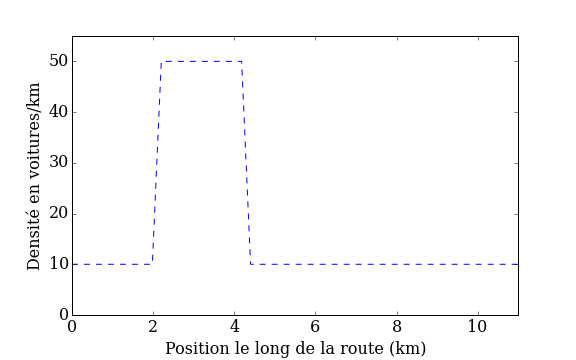
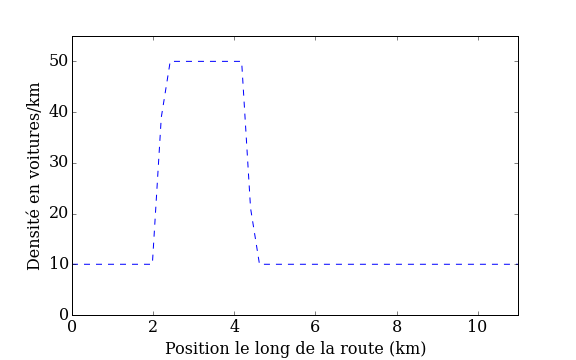
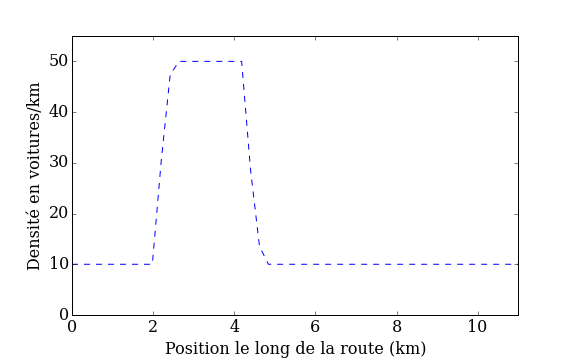
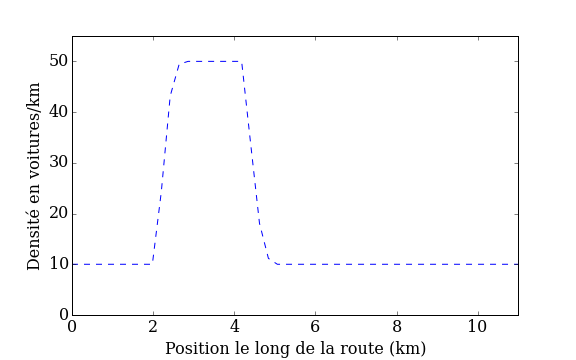
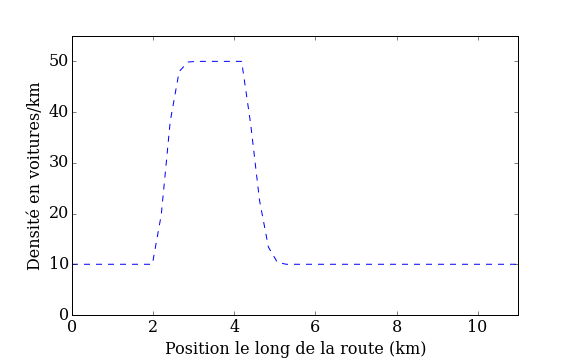
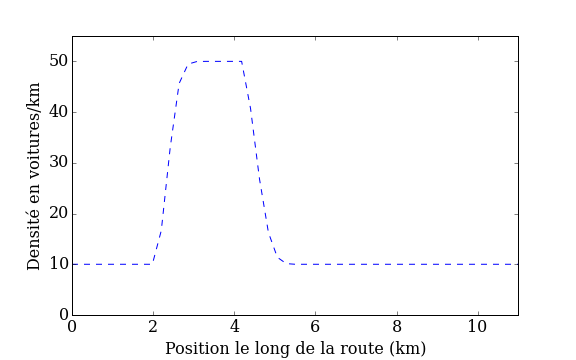
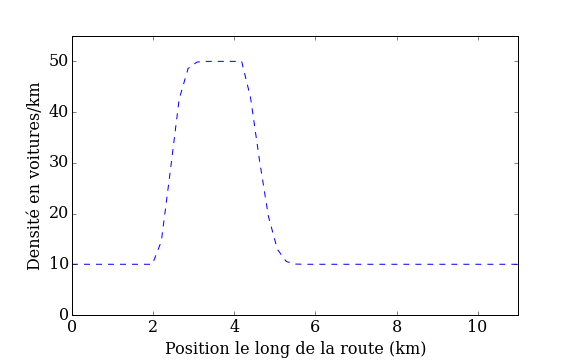
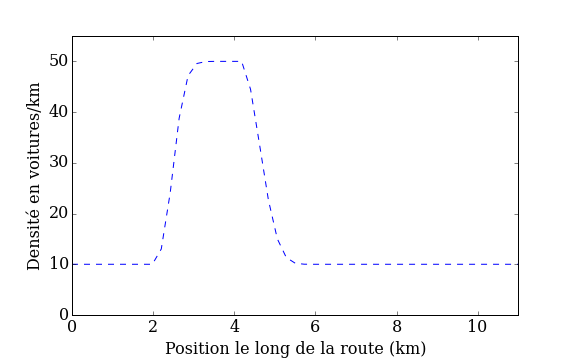
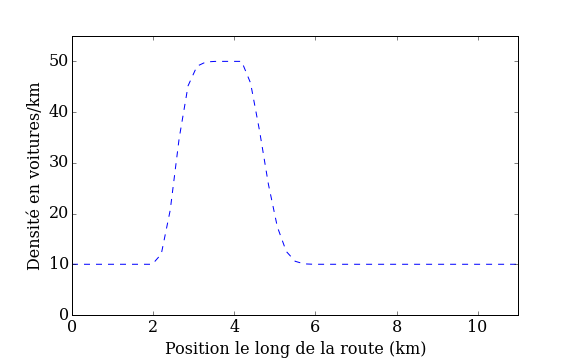
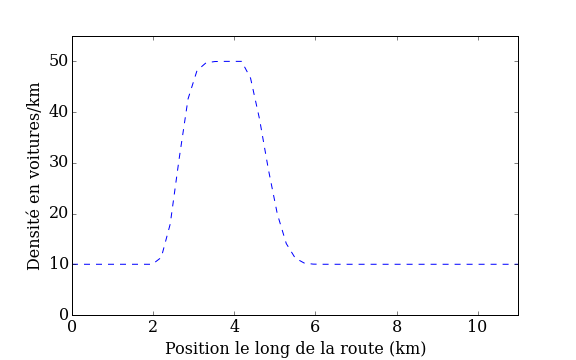
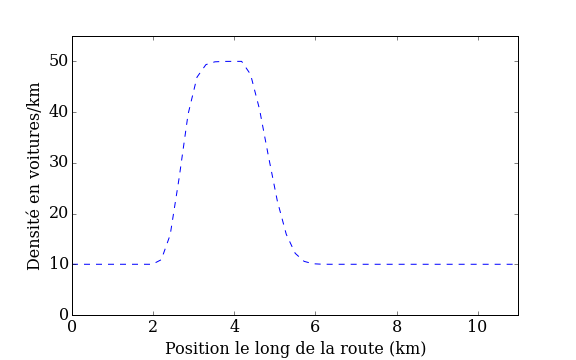
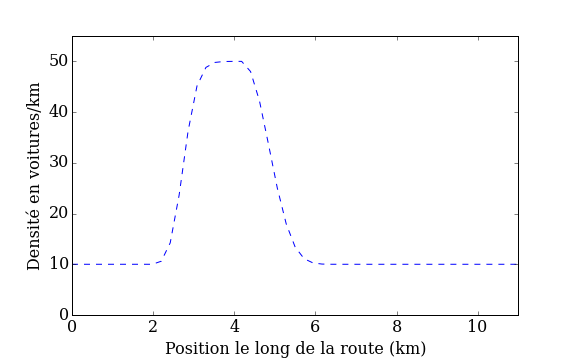
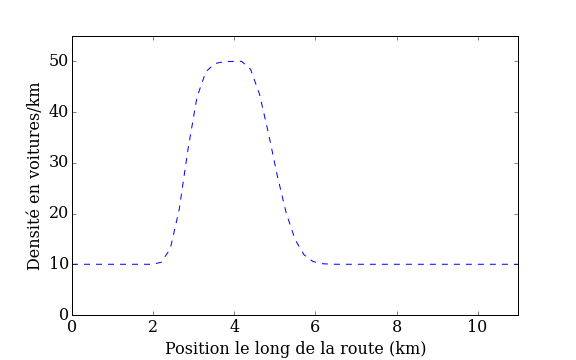
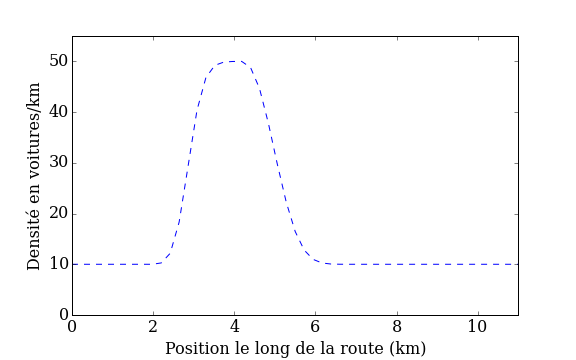
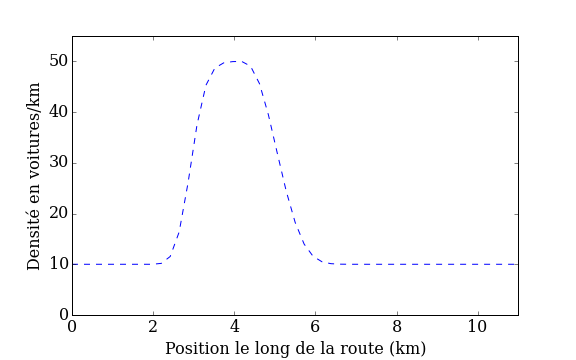
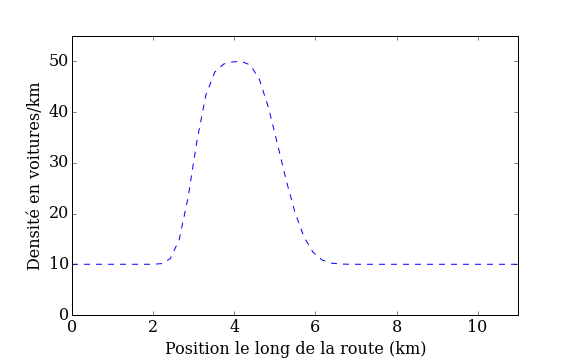
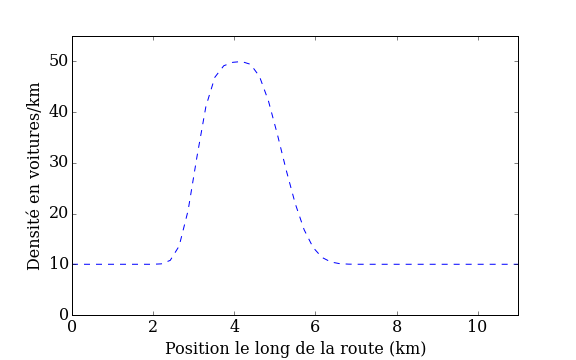
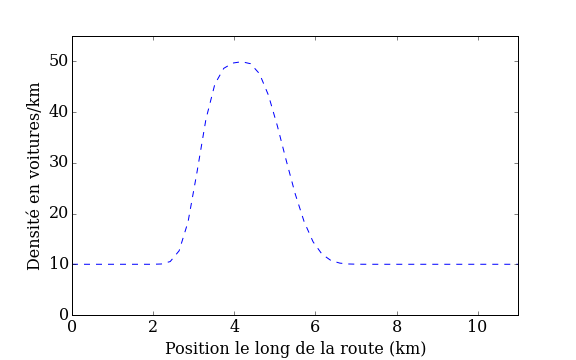
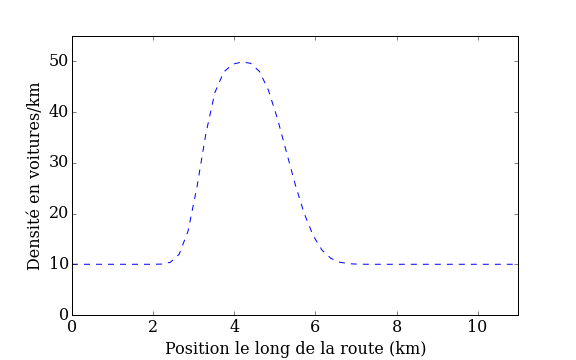
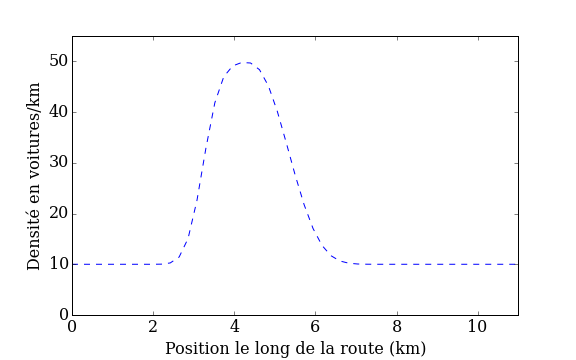
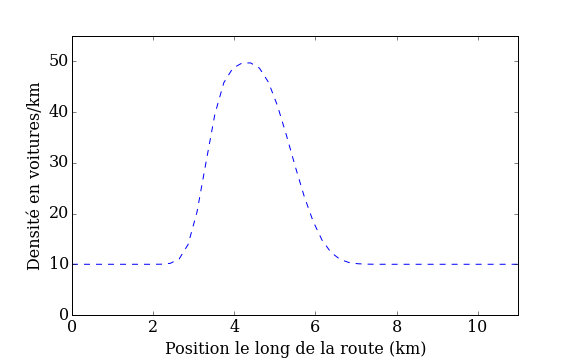
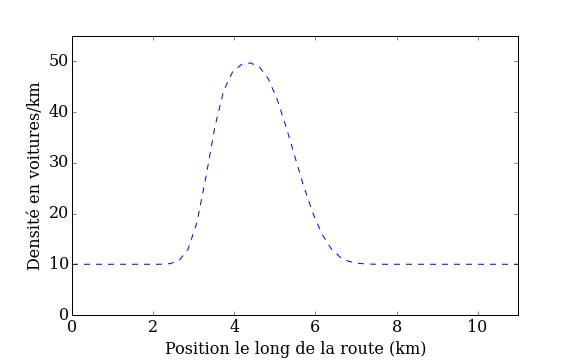
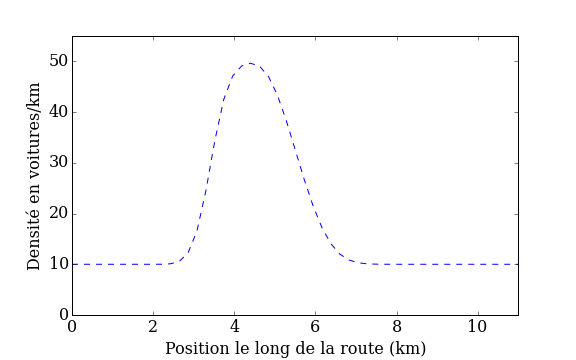
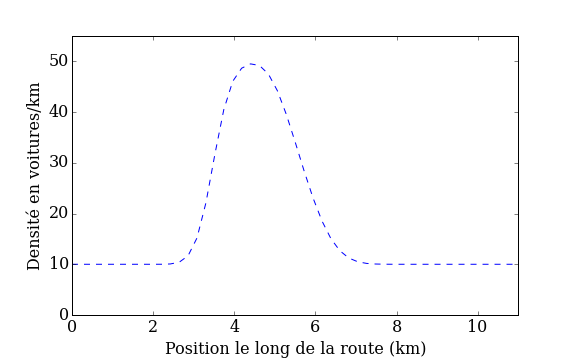
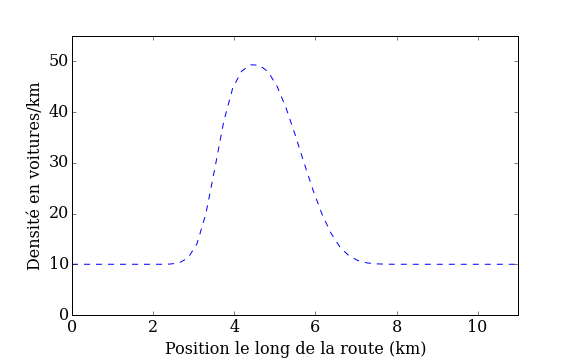
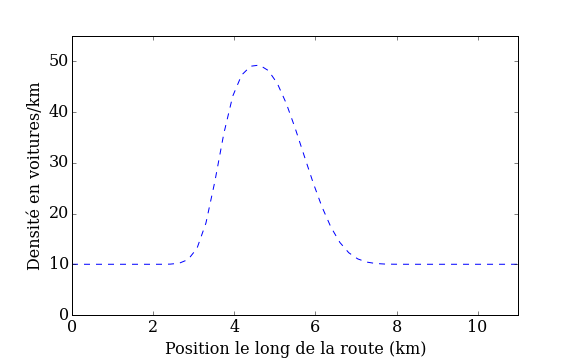
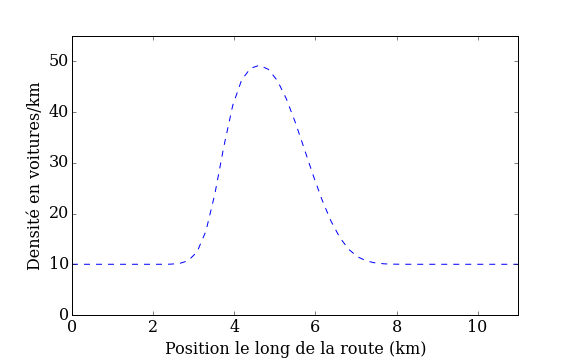
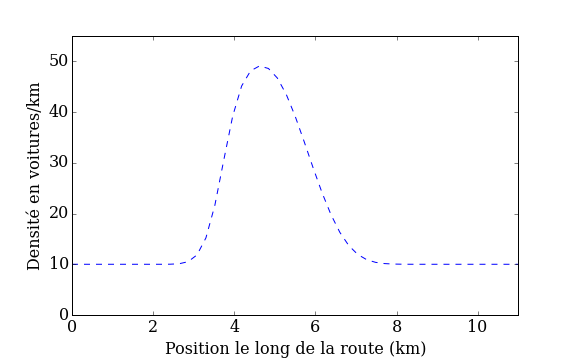
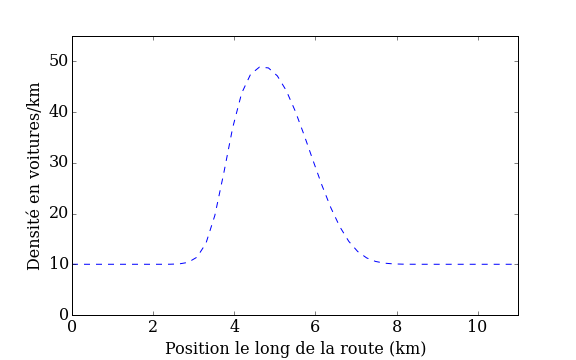
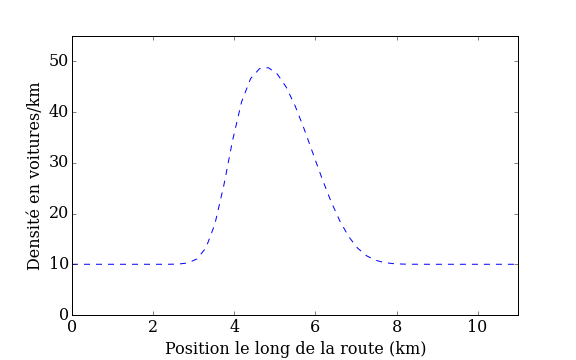
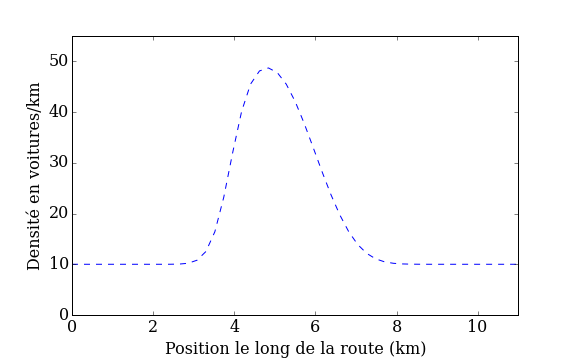
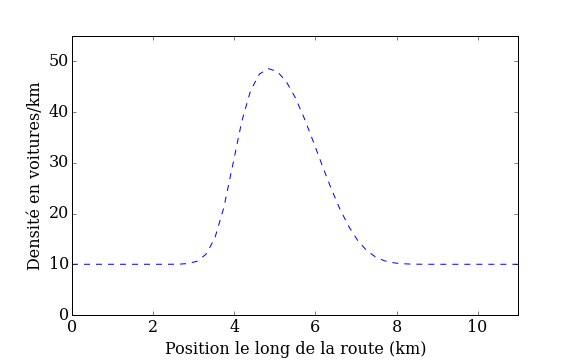
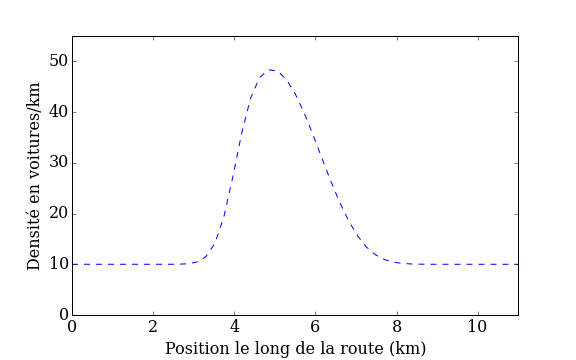
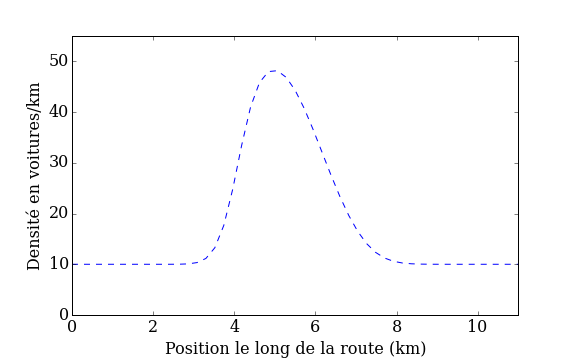
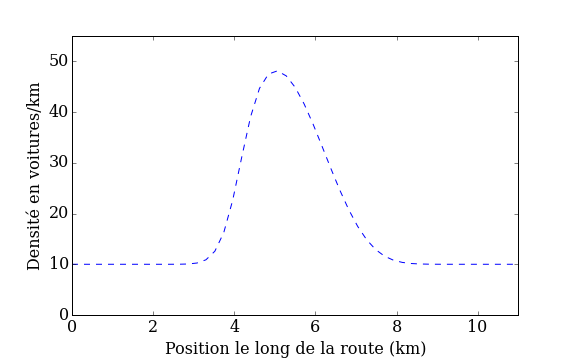
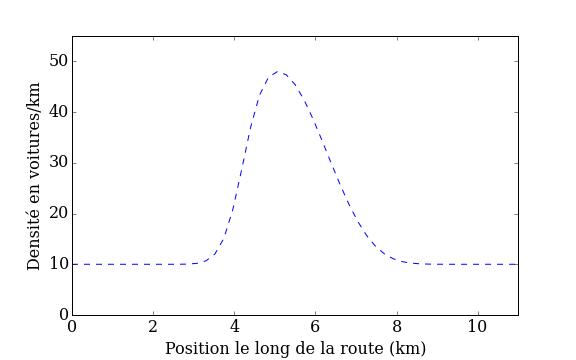
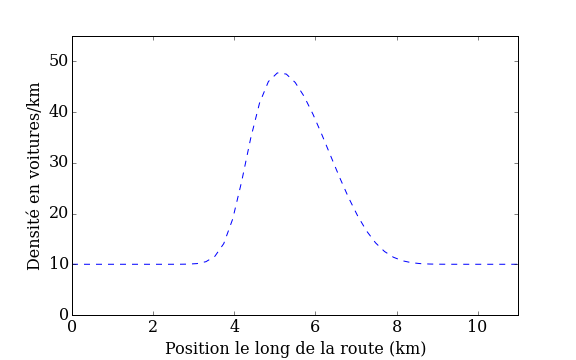
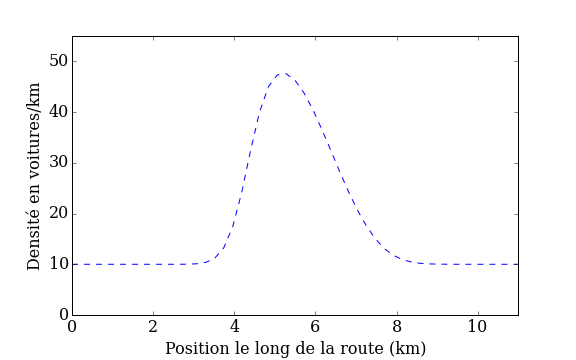
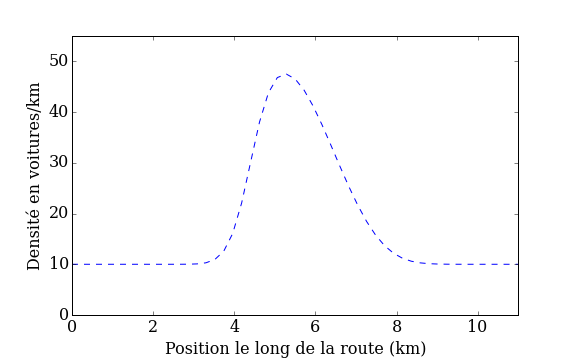
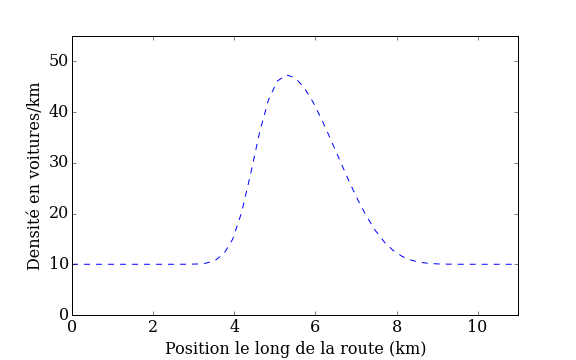
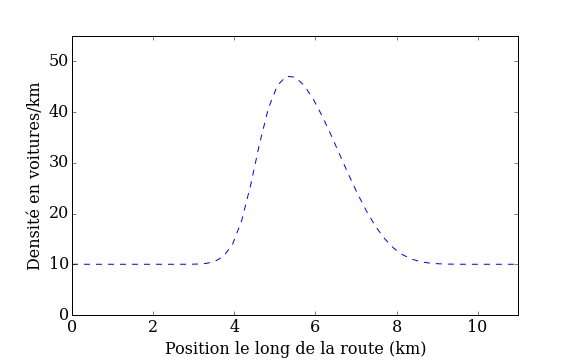
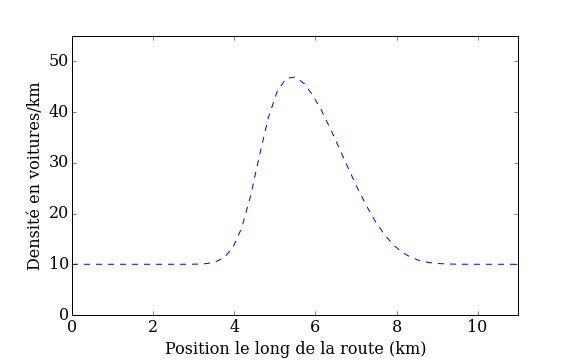
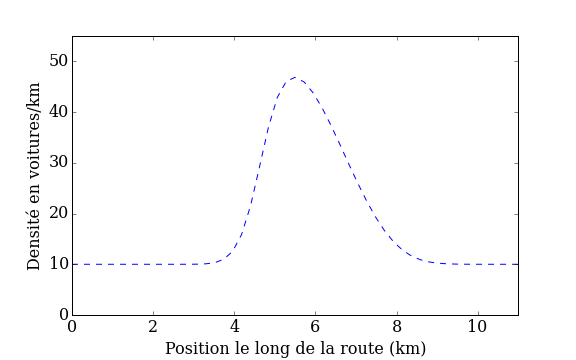
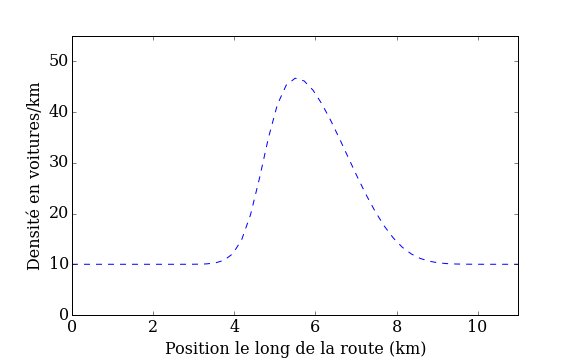
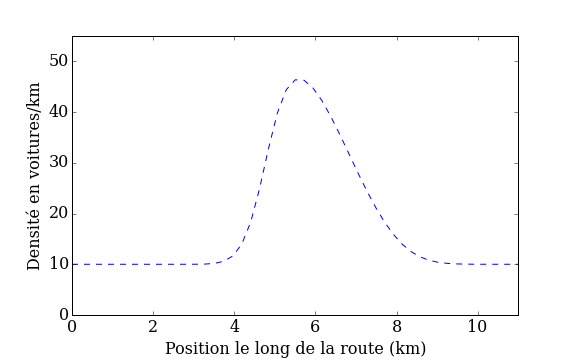
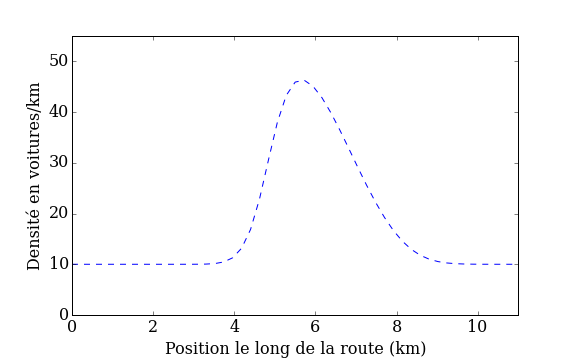
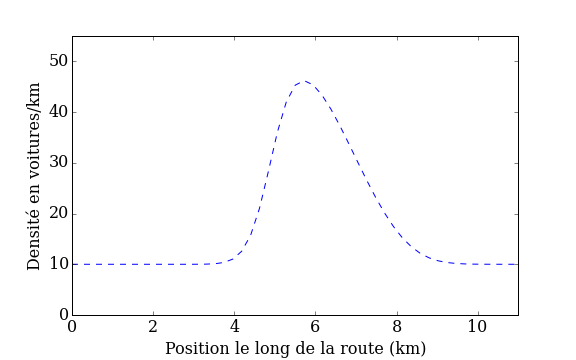
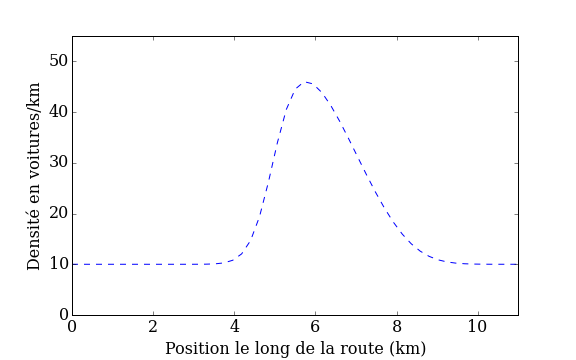
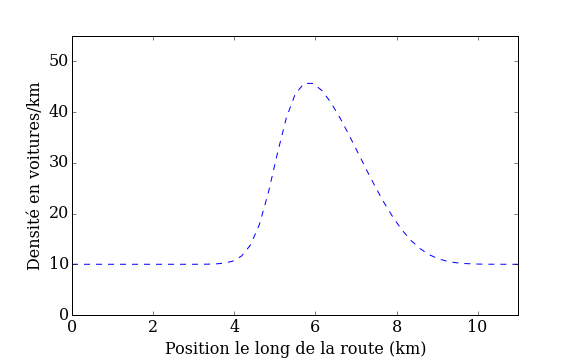
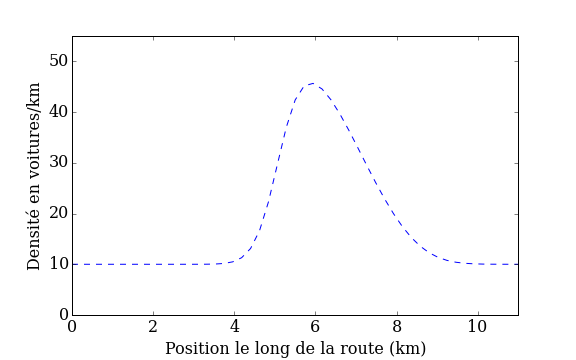
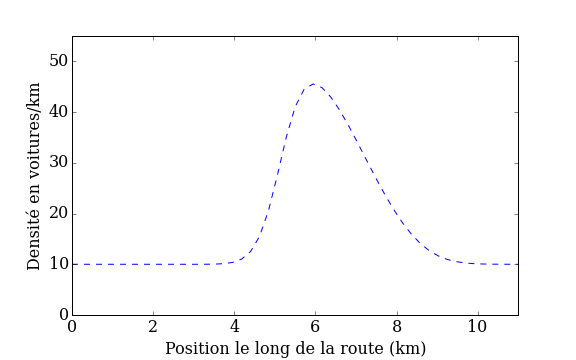
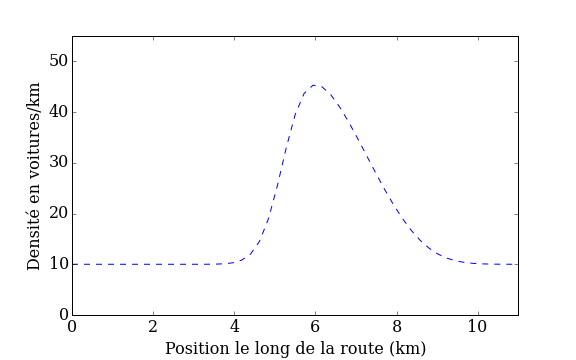
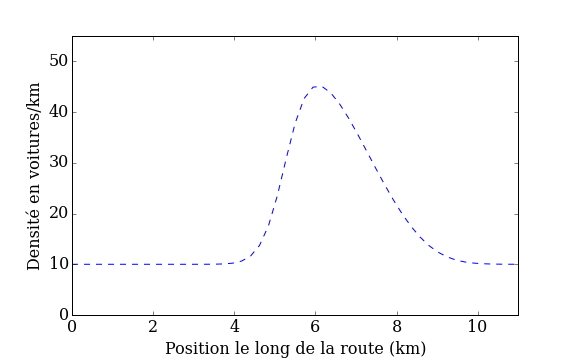
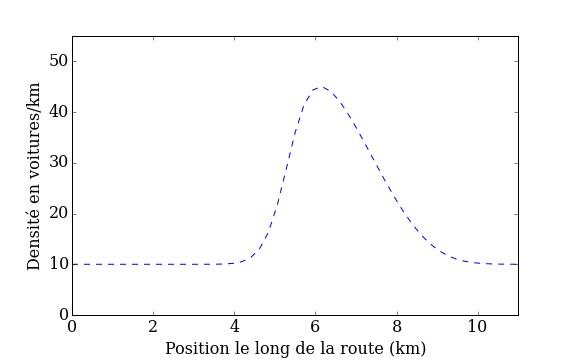
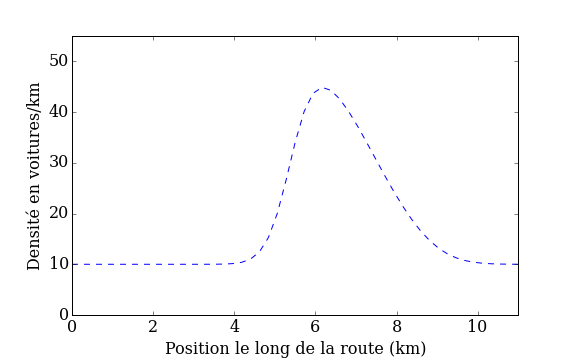
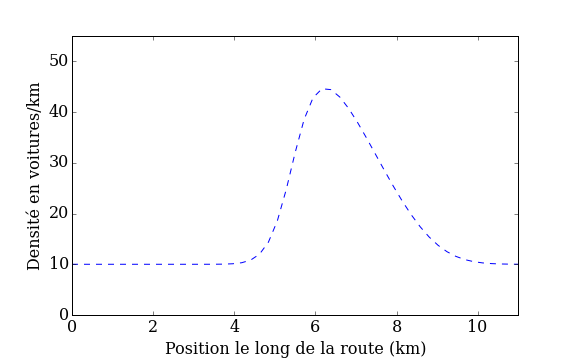
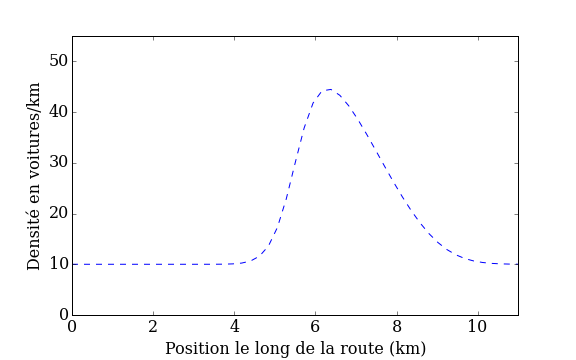
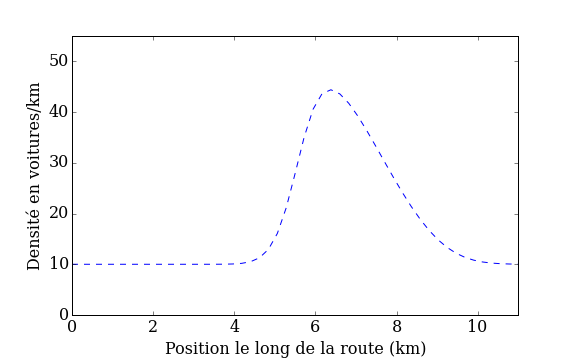
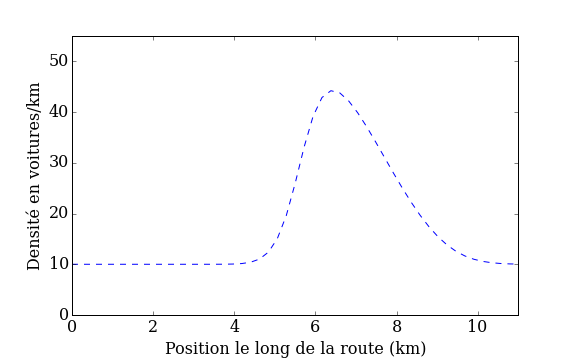
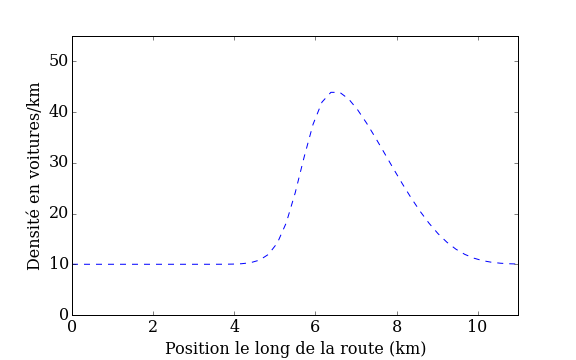
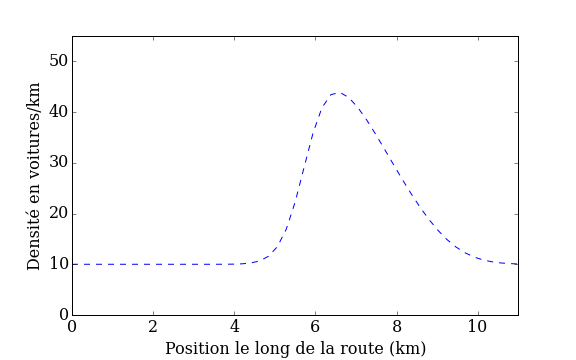
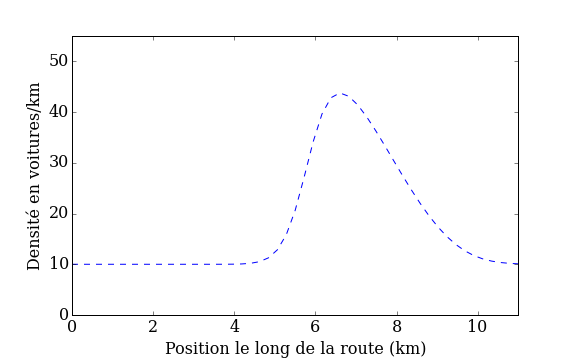
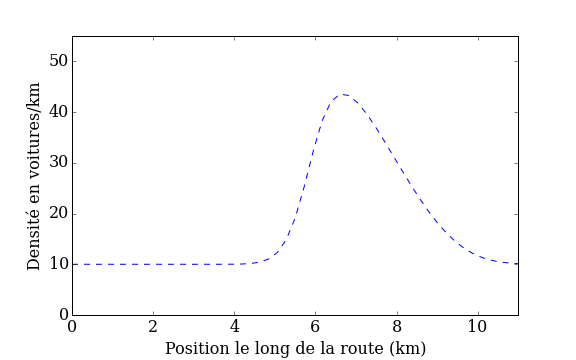
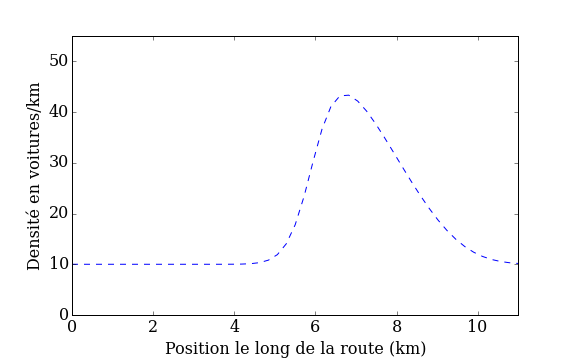
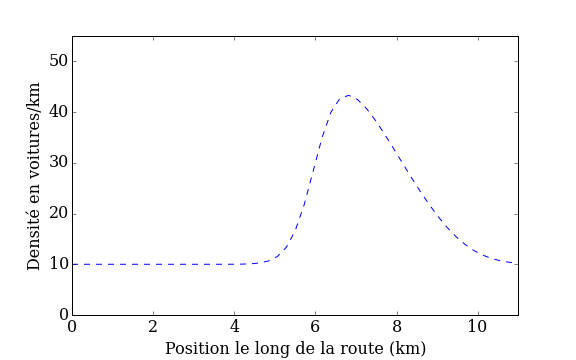
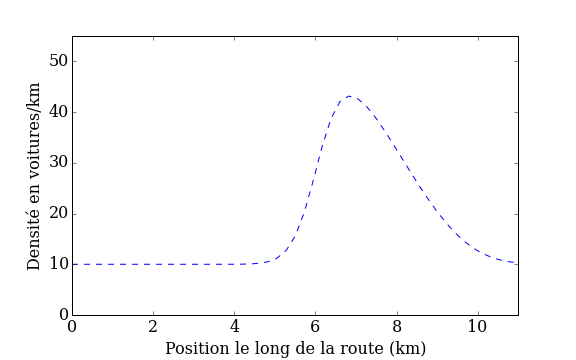
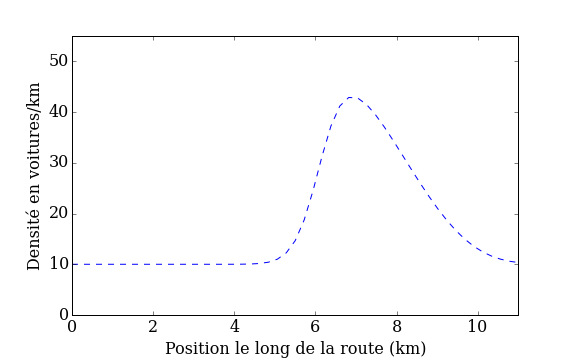
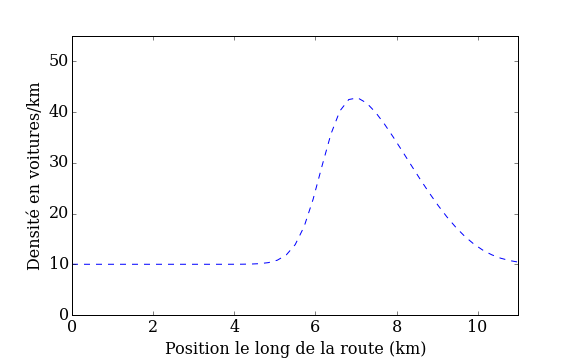
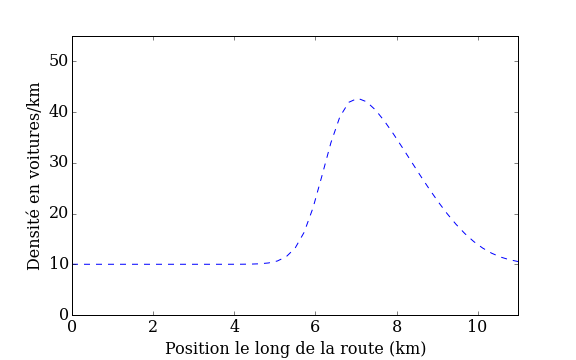
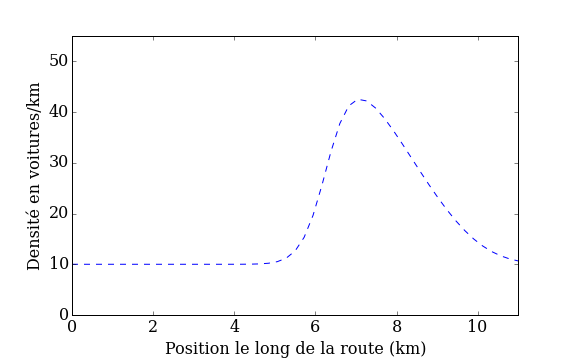
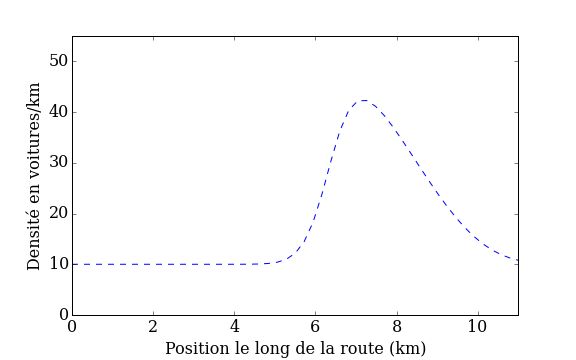
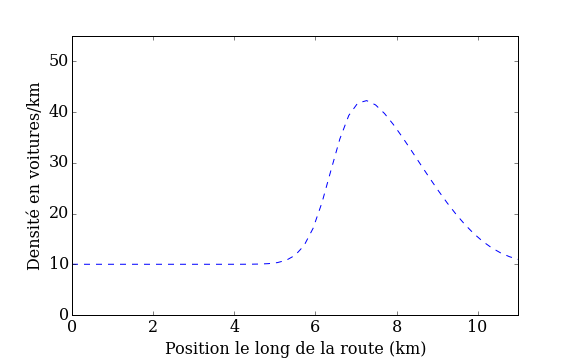
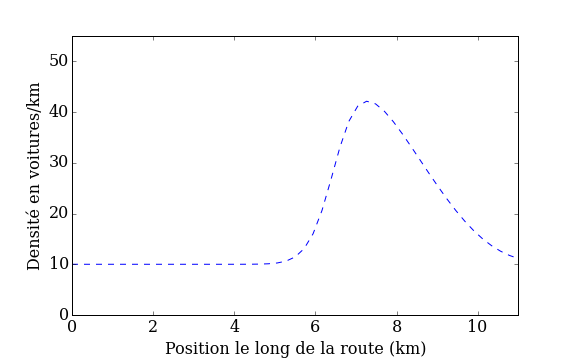
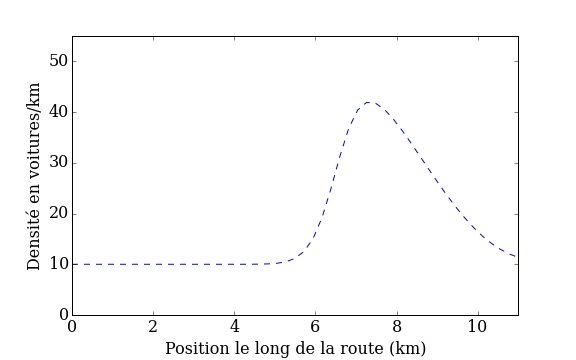
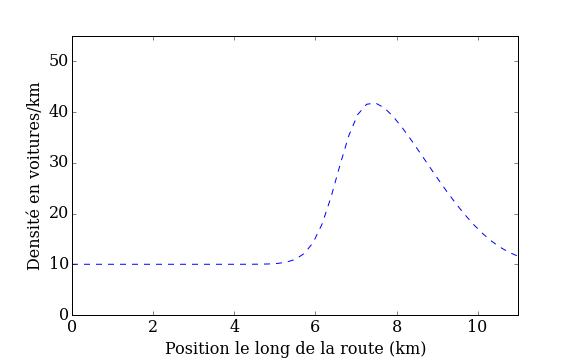
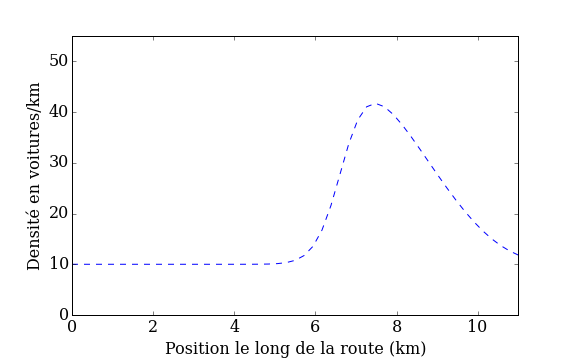
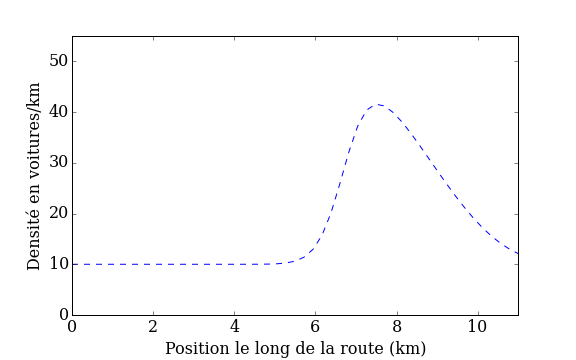
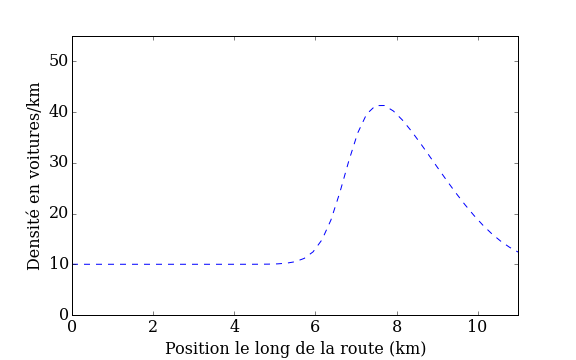
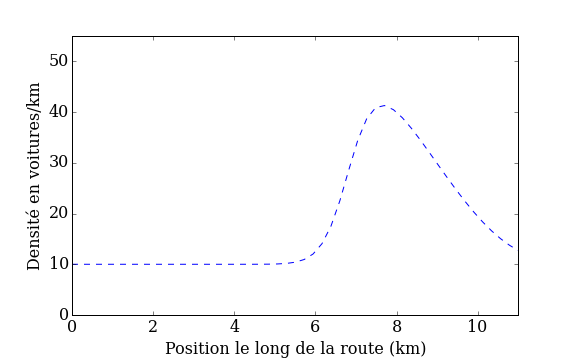
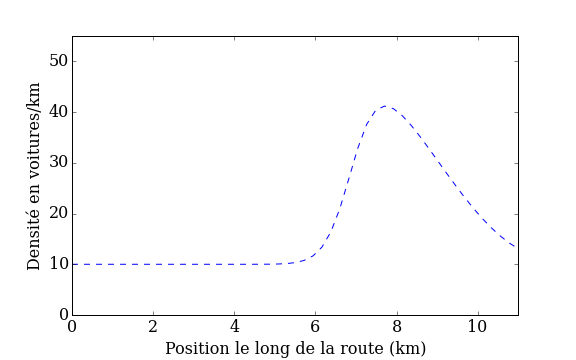
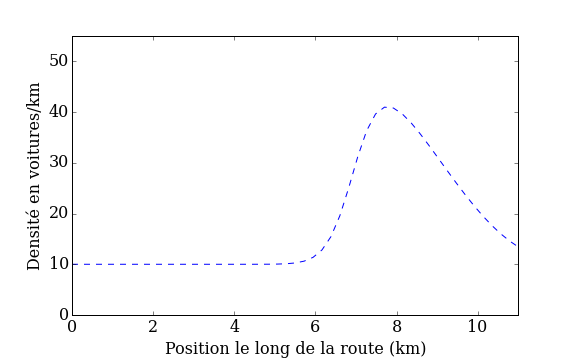
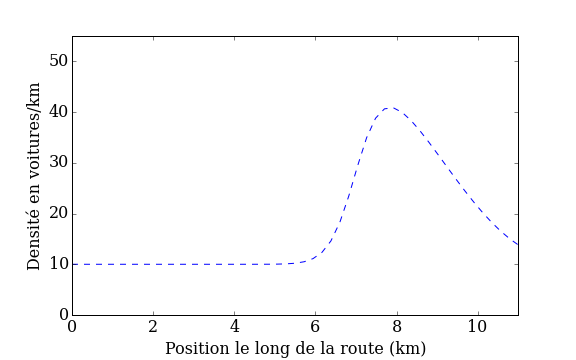
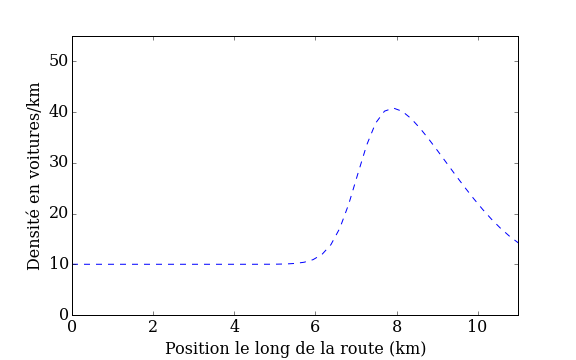
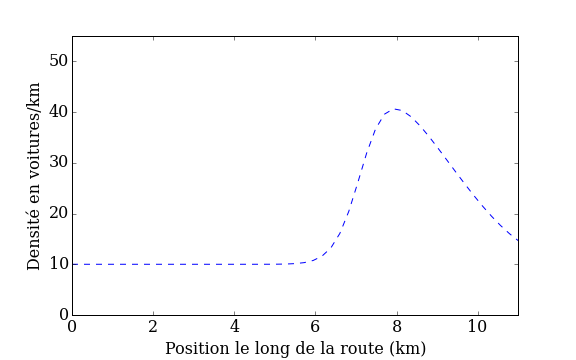
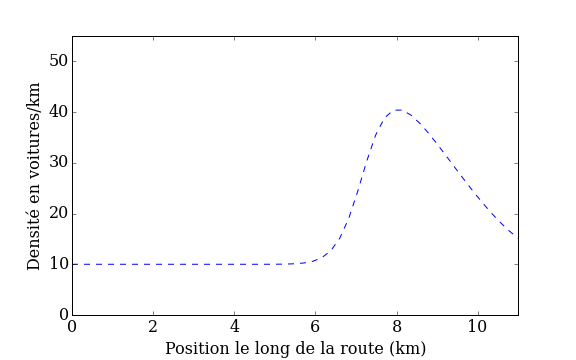
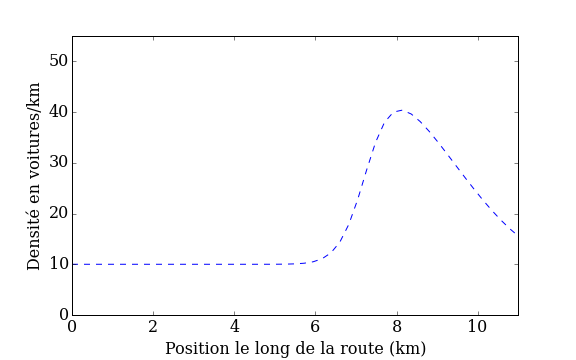
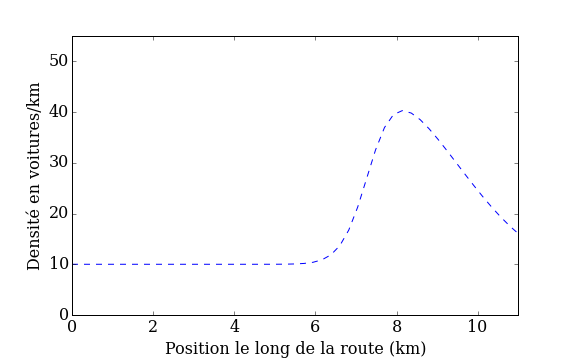
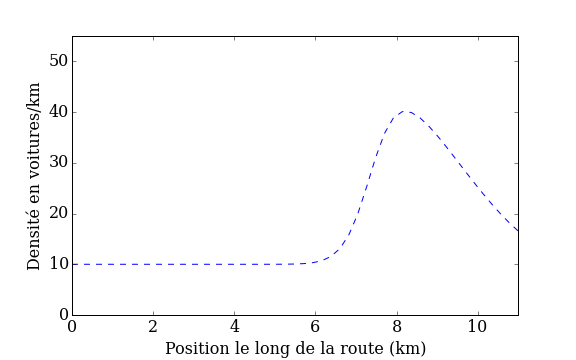
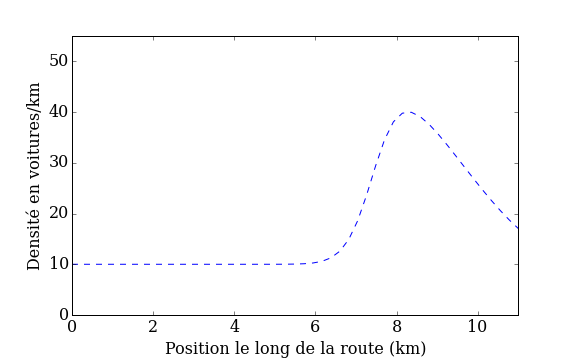
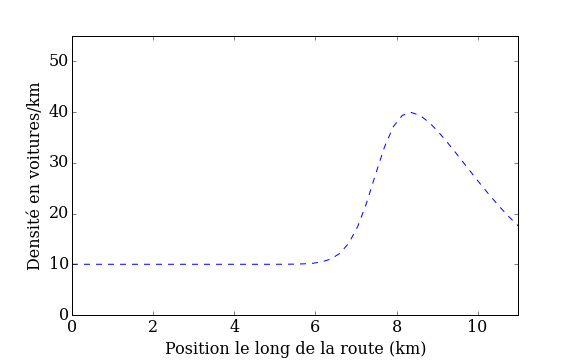
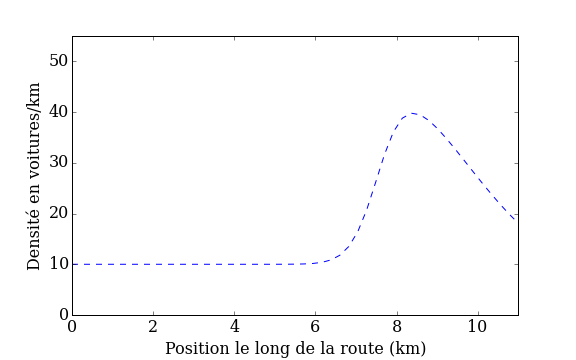
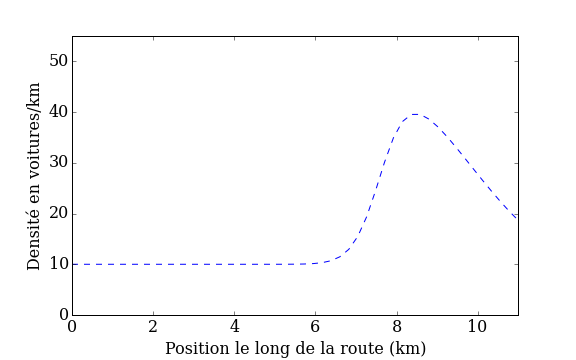
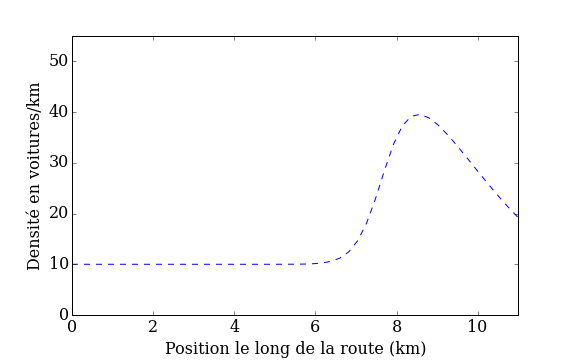
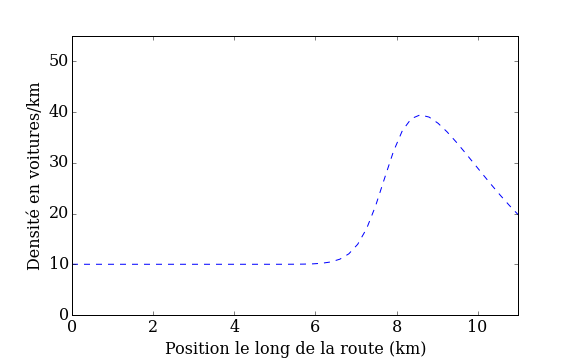
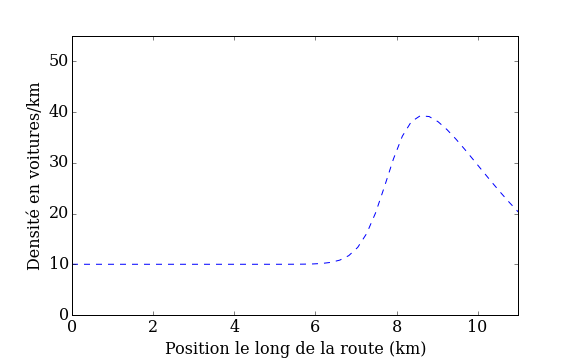
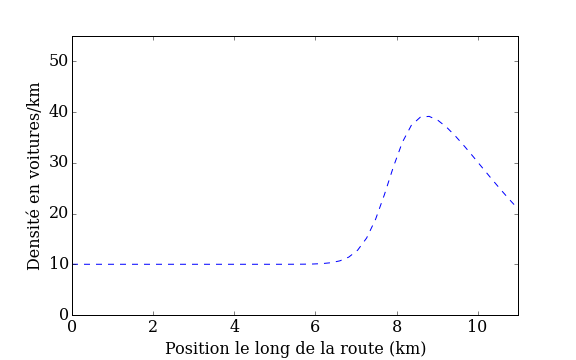
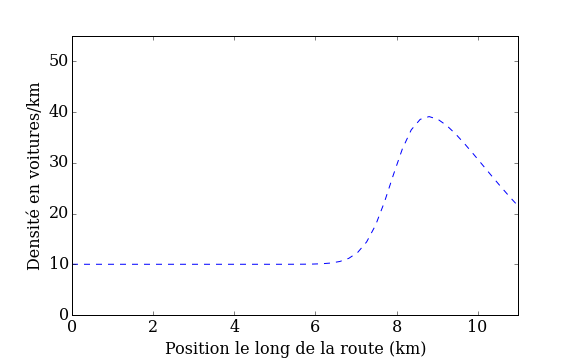
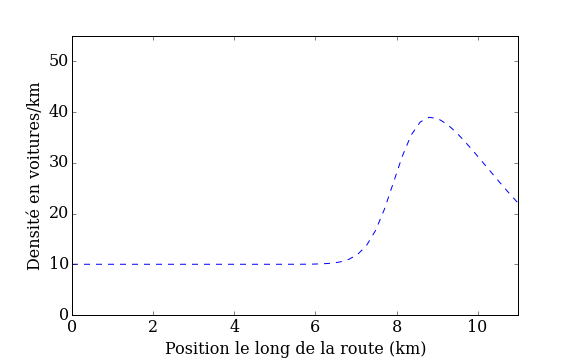
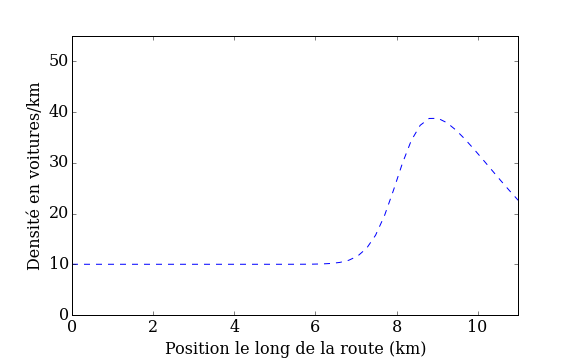
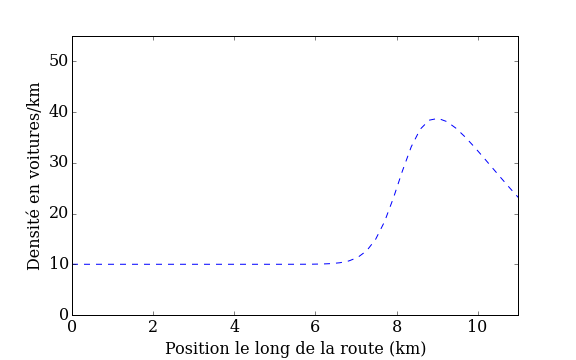
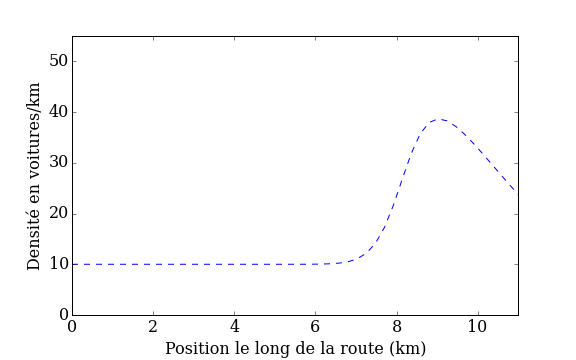

In [34]:
animationdensite(80,10,.1)


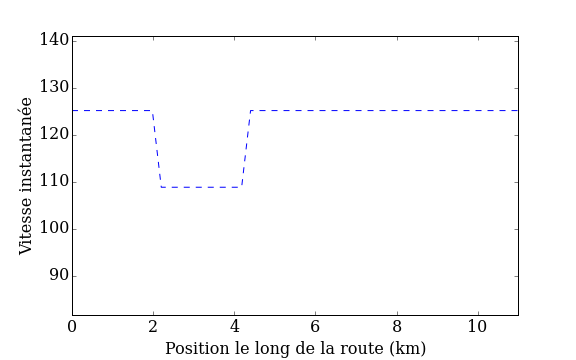
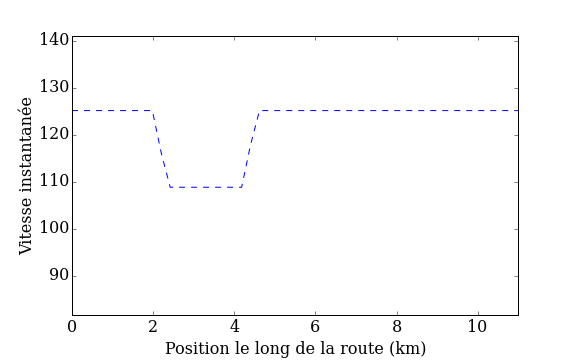
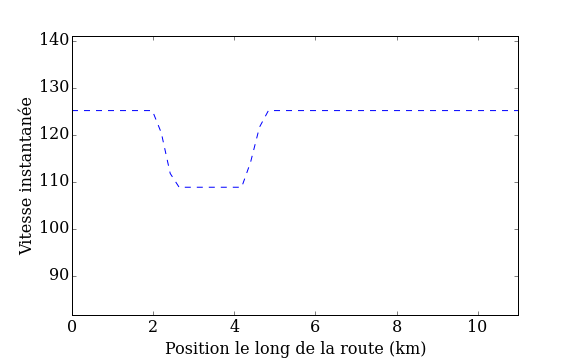
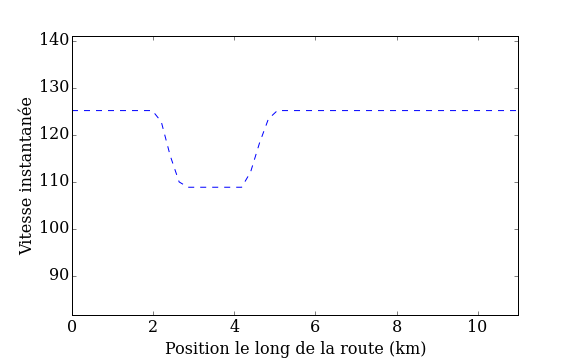
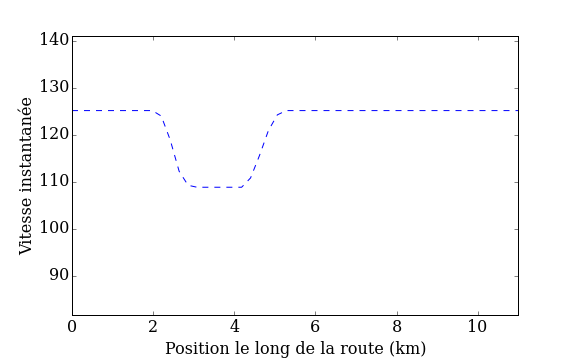
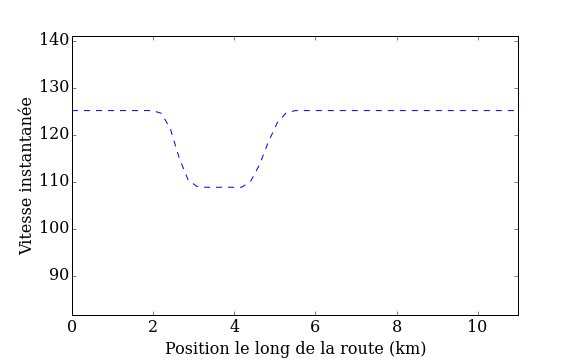
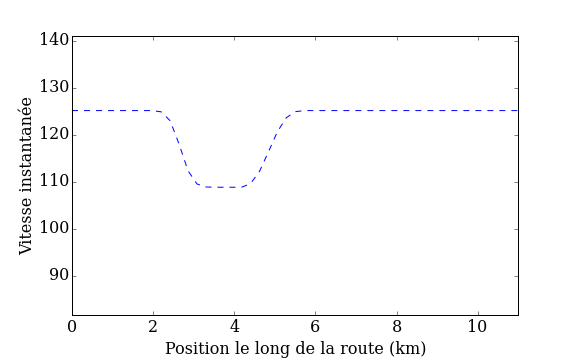
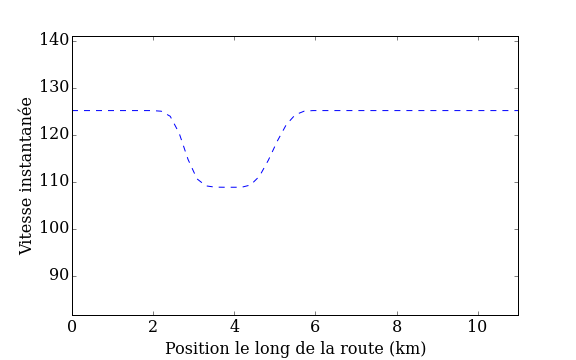
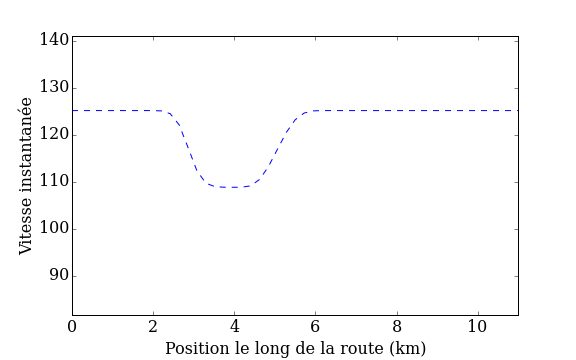
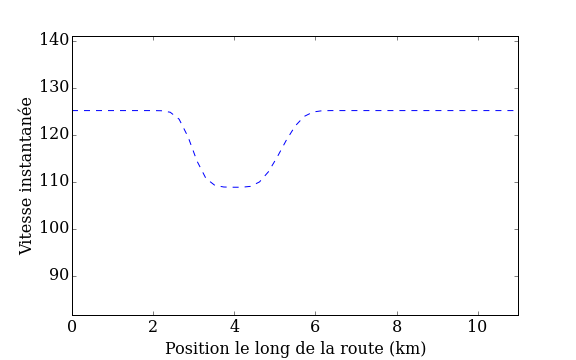
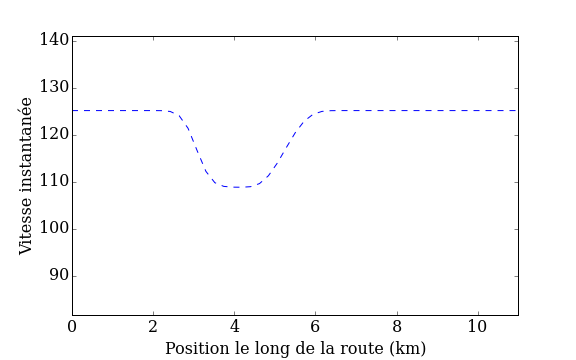
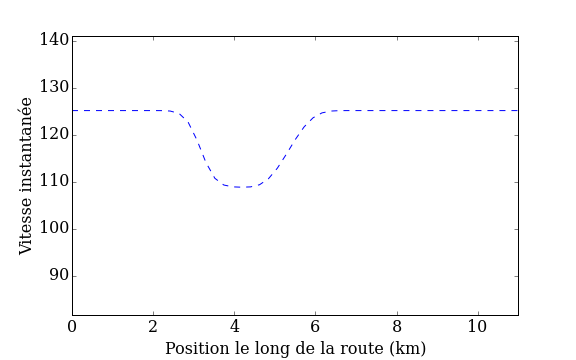
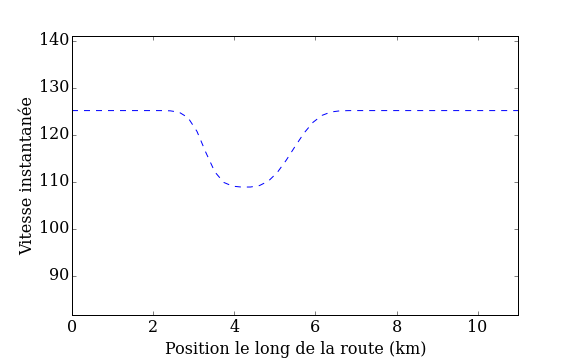
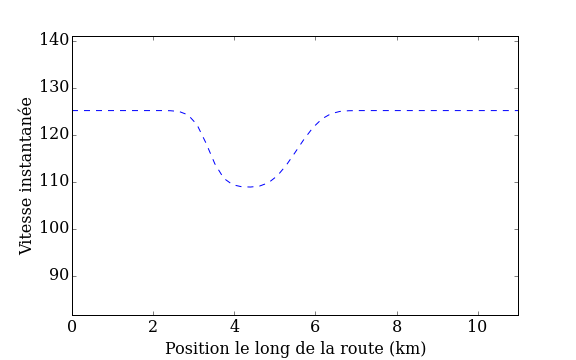
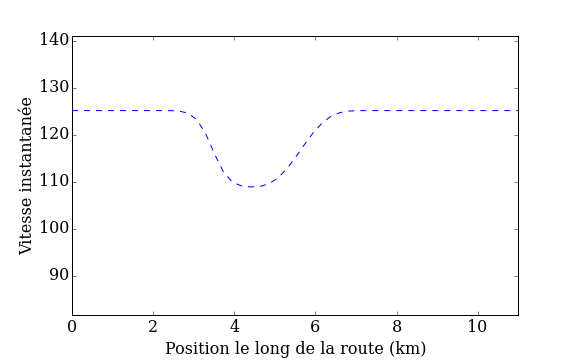
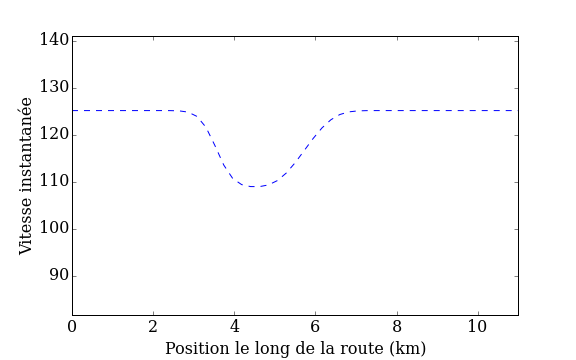
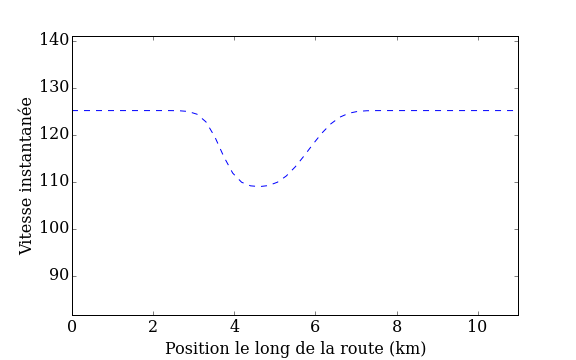
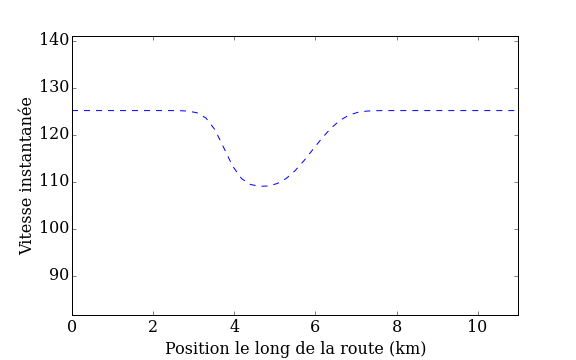
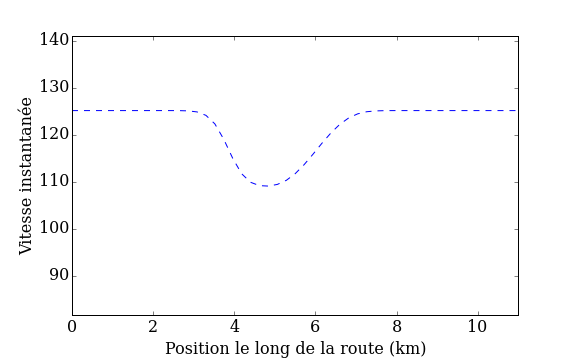
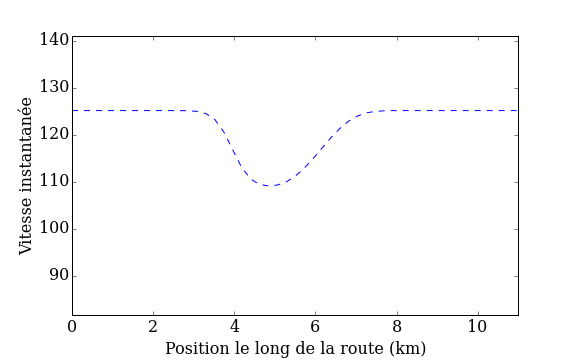
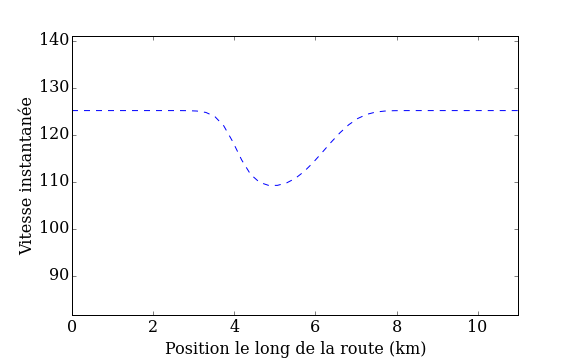
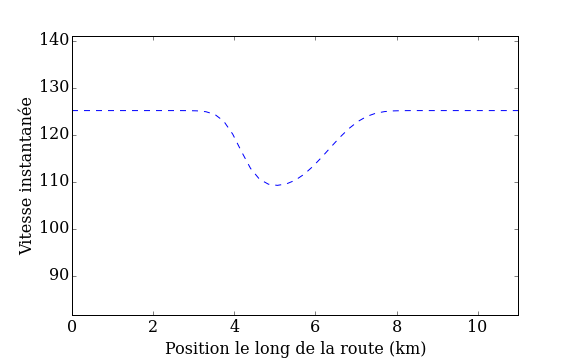
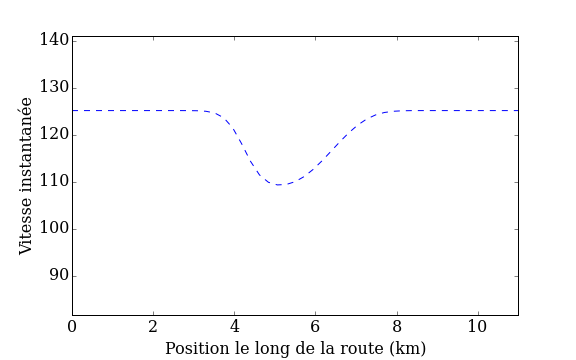
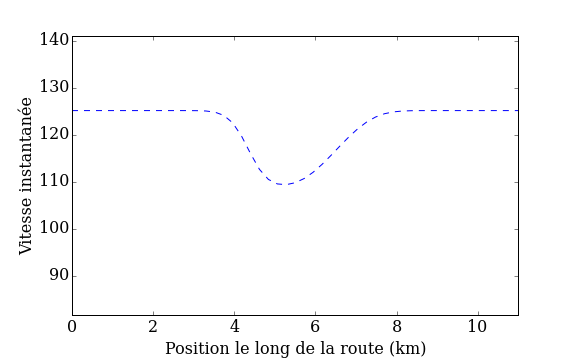
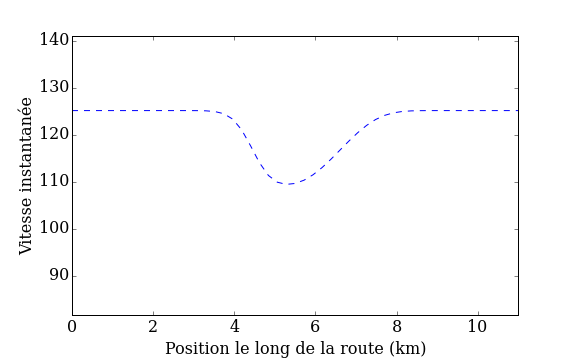
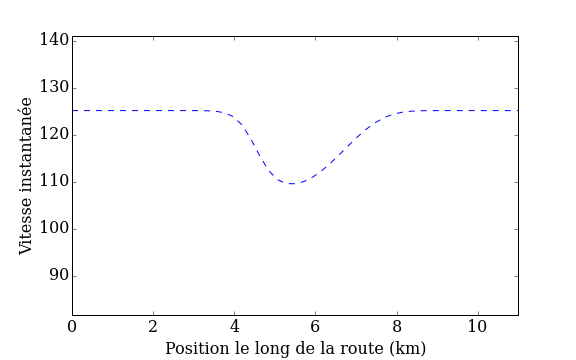
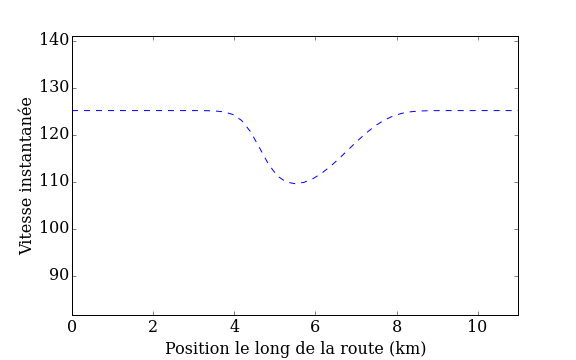
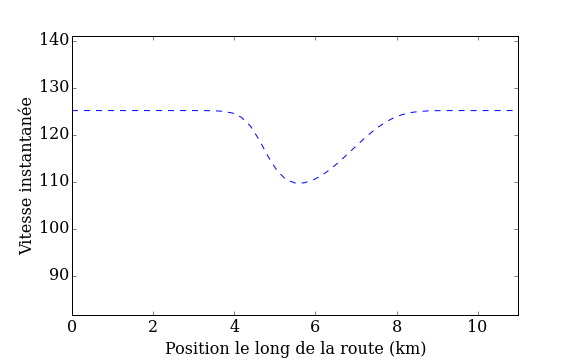
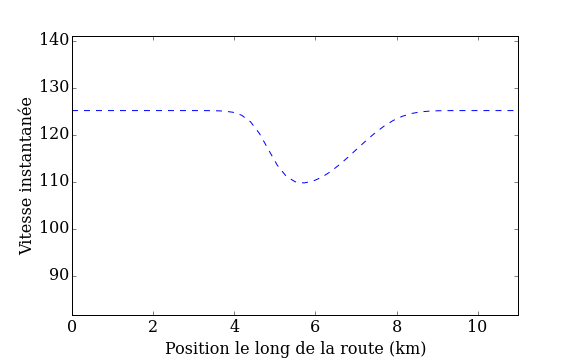
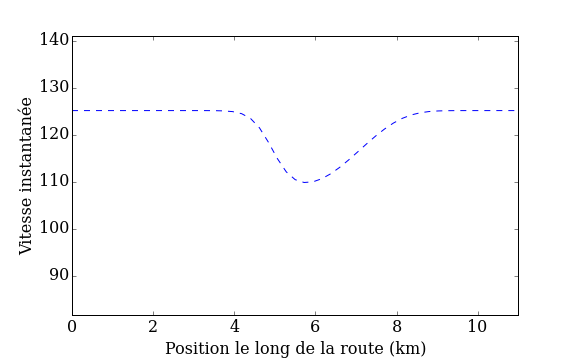
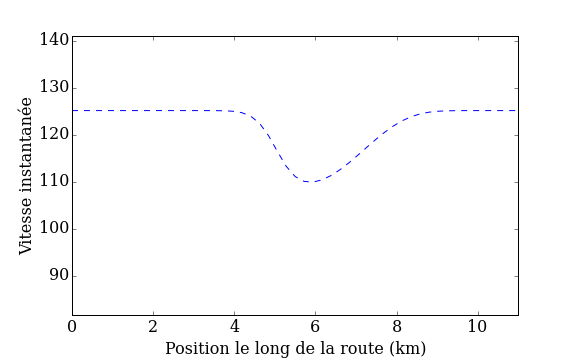
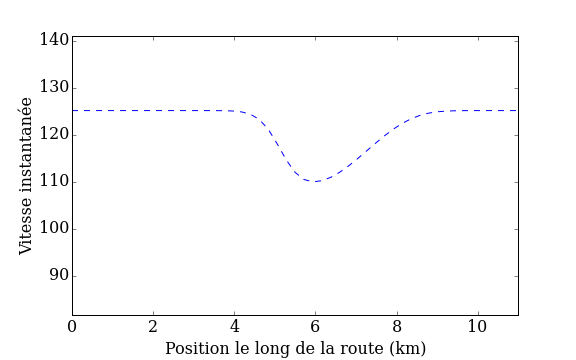
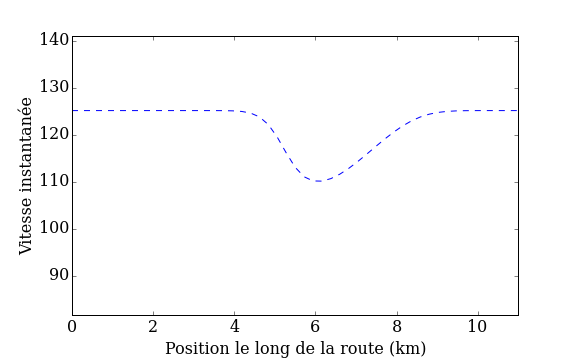
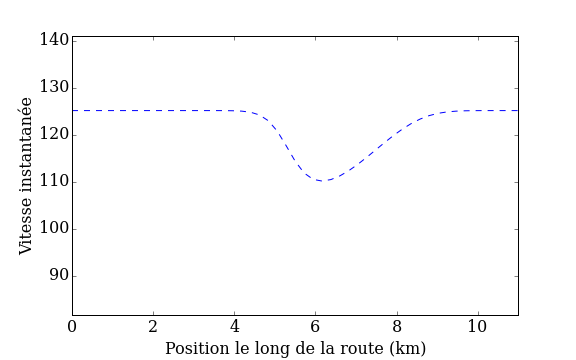
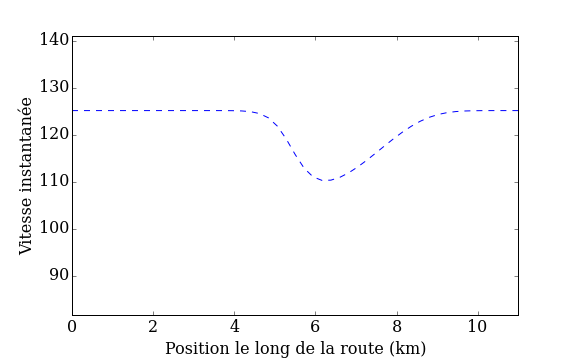
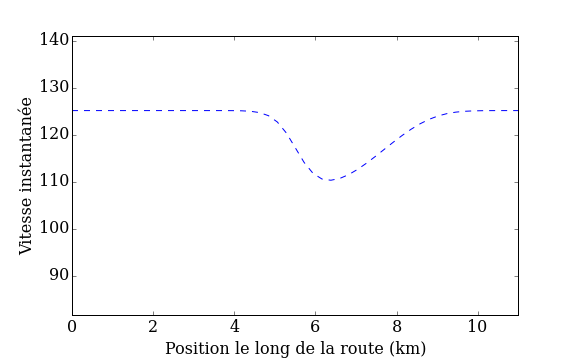
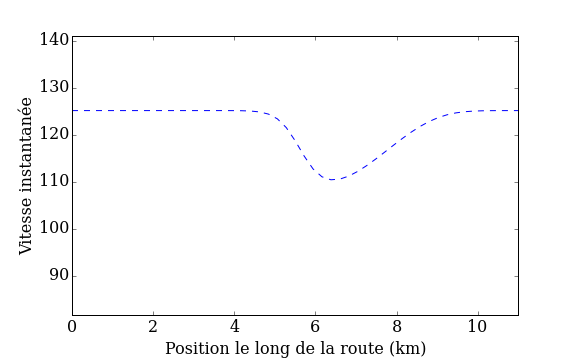
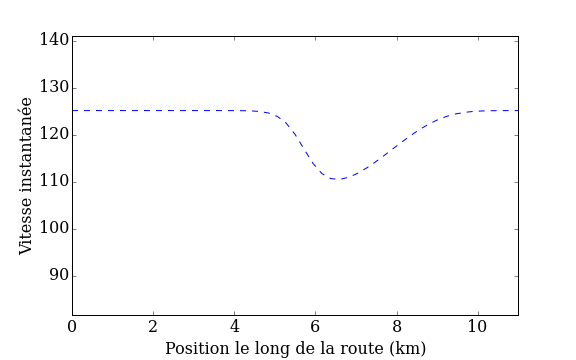
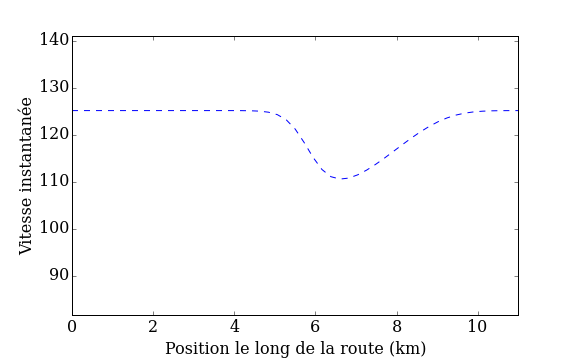
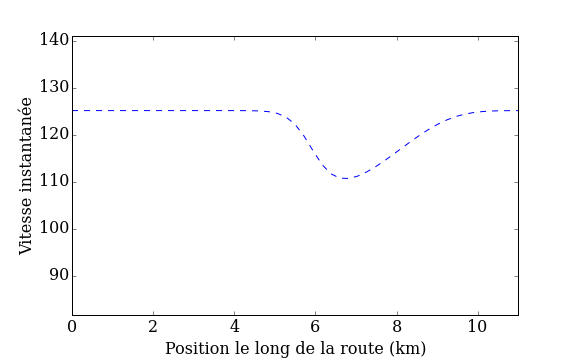
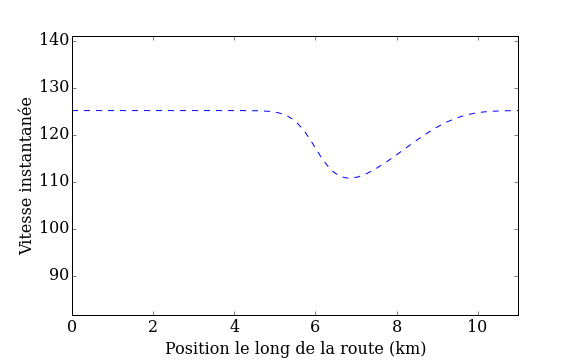
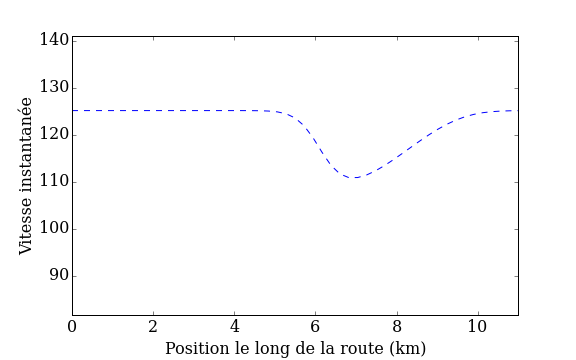
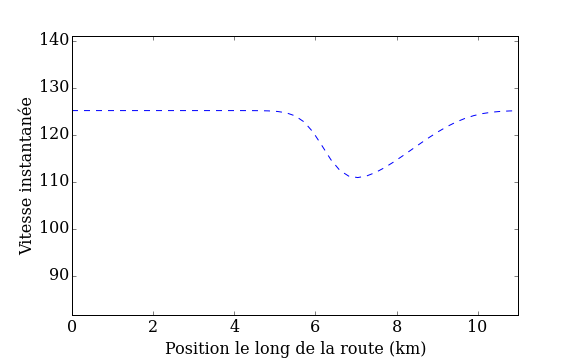
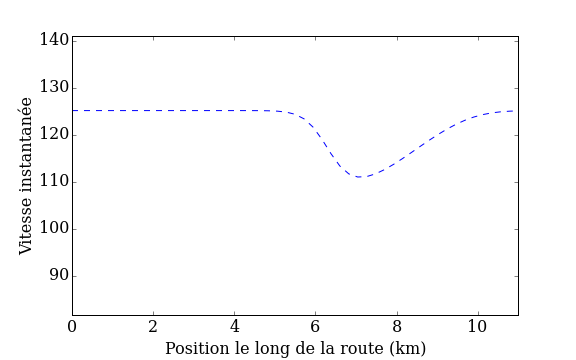
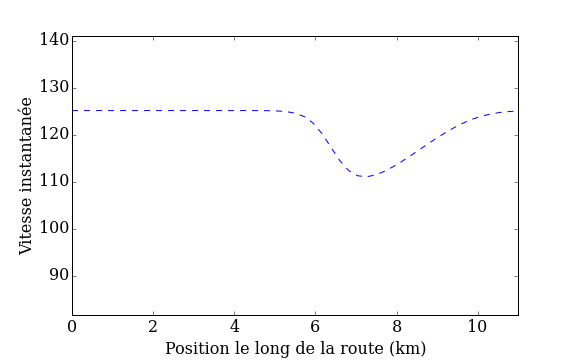
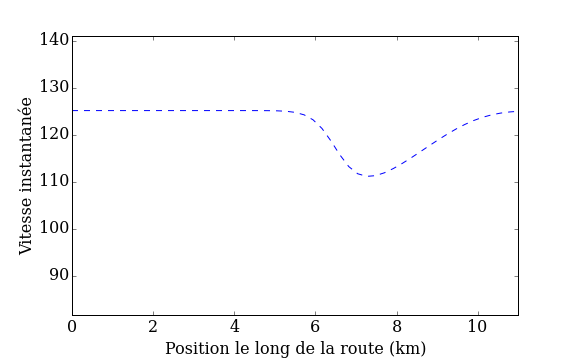
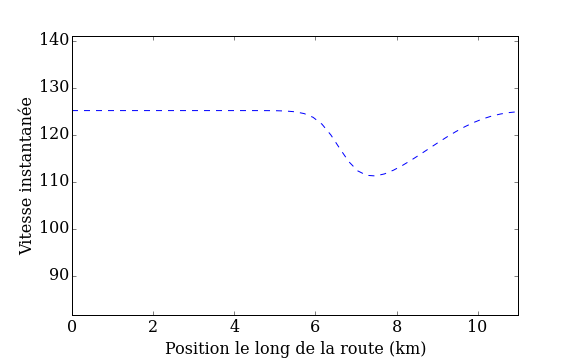
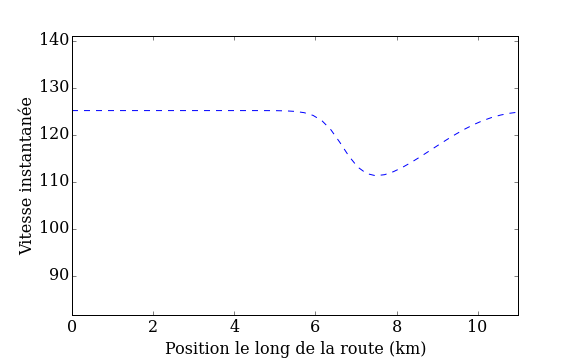
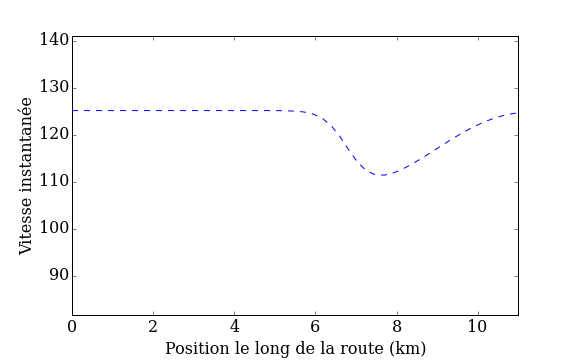
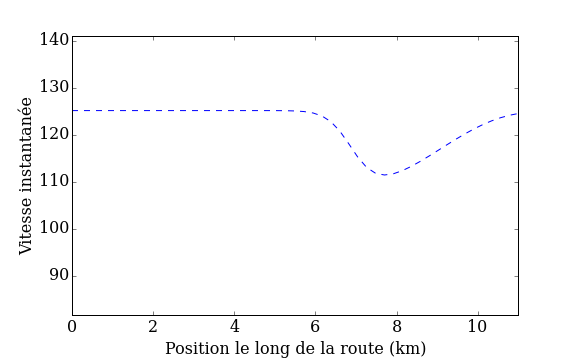
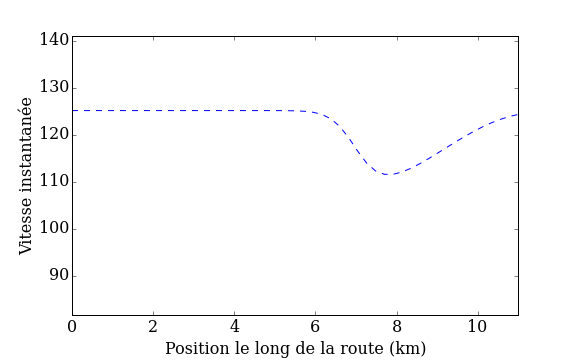

In [31]:
animationvitesse(136,20,0.05)

# CONCLUSION

Nous avons utilisé ici un modèle très simplifié pour décrire l'évolution de la circulation sur une route au moyen d'une équation de diffusion. Si on introduisait plus de précision dans le modèle, la résolution numérique de l'équation différentielle pourrait être une bonne approximation de différentes situations réelles.

Les seuls problèmes qui peuvent apparître sont liés à la quantité de données à emmagasiner, surtout si on veut augmenter la précision. Nous avons essayé d'optimiser les temps de calculs, mais nous ne pouvons pas nous passer des multiples tableaux. D'autres méthodes doivent être encore développées si c'est possible.